In [1]:
from pypei import modeller, objective

import casadi as ca
import numpy as np
from copy import copy
import pandas as pd
import datetime

In [29]:
from matplotlib import pyplot as plt
from matplotlib import font_manager
import matplotlib.cm as mplcm
import matplotlib.colors as colors


%matplotlib inline

label_font = font_manager.FontProperties(
    family=['Fira Sans'],
    weight='regular',
    size=20
)
tick_font = font_manager.FontProperties(
    family=['Fira Sans'],
    weight='regular',
    size=14
)

In [8]:
def seir_model(t, y, p):
    b, g, e, d, a, m = p[:6]
    S,E,I,H,G,R,D,cE,cH = y[:9]
    return [
        -b*S*I/(S+E+I+R+G+H),
        b*S*I/(S+E+I+R+G+H)-g*E,
        g*E-(e+a+m)*I,
        e*I-d*H,
        d*H,
        e*I,
        m*I,
        g*E,
        e*I
    ]

In [4]:
read_file = True
if read_file:
    raw_data = pd.read_csv("../samoa-data/samoa_press_release_data.csv", header=0, dayfirst=True, parse_dates=True, skiprows=[1])
time, cE, H, cH, D, G = raw_data.iloc[:,1:].values.T

In [5]:
the_dates = list(map(lambda t: datetime.datetime.strptime(t, "%d/%m/%Y"), raw_data.Date.values))
def time_conv(time: float):
    return the_dates[0] + datetime.timedelta(days=time)

In [9]:
data_pd = np.vstack([H, G, D, cE, cH]).astype(float).T
start = 0
clip = 17
data_time = time[start:clip]
data_pd = data_pd[start:clip,:]

p0 = [2, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6]
config = {
    "grid_size": 200,
    "basis_number": 40,
    "model_form": {
        "state": 9,
        "parameters": 6
    },
    "time_span": [time[0], time[-1]*1.25],
    "knot_function": None,
    "model": seir_model,
    "dataset": {"y": data_pd, "t": np.array(data_time)},
    "observation_vector": [3,4,6,7,8],
    "weightings":[
        [1]*9,
        np.sqrt((data_time+1)/np.mean(data_time+1))
    ],
    "regularisation_value": copy(p0),
}

In [12]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
config['regularisation_value'][2] = model.ps[2]
obj_fn = objective.Objective()
obj_fn.make(config, model)

solver_setup = {
    'f': obj_fn.objective,
    'x': ca.vcat(obj_fn.input_list),
    'p': ca.hcat([obj_fn.rho, obj_fn.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 50,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [17]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [obj_fn.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [obj_fn.obj_2])
fr_ex = ca.Function('fr_ex', [solver_setup['x']], [obj_fn.regularisation])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)

In [15]:
c0 = [2500*np.ones(config['basis_number']) for _ in range(9)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*9) + [0]*len(config['regularisation_value'])
alpha = 3e1

In [16]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0


1700  3.8180856e+01 0.00e+00 3.52e-04  -9.0 5.07e+02    -  1.00e+00 1.00e+00h  1
1750  3.8180856e+01 0.00e+00 1.21e-04  -9.0 3.12e+02    -  1.00e+00 1.00e+00h  1
1800  3.8180856e+01 0.00e+00 2.16e-03  -9.0 5.29e+03    -  1.00e+00 2.50e-01h  3
1850  3.8180855e+01 0.00e+00 1.78e-03  -9.0 2.01e+04    -  1.00e+00 6.25e-02h  5
1900  3.8180855e+01 0.00e+00 7.60e-06  -9.0 9.69e+01    -  1.00e+00 1.00e+00h  1
1950  3.8180855e+01 0.00e+00 1.33e-03  -9.0 1.17e+03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  3.8180855e+01 0.00e+00 1.65e-03  -9.0 5.20e+03    -  1.00e+00 2.50e-01h  3
2050  3.8180855e+01 0.00e+00 3.68e-03  -9.0 4.07e+03    -  1.00e+00 5.00e-01h  2
2100  3.8180855e+01 0.00e+00 3.15e-03  -9.0 3.85e+03    -  1.00e+00 5.00e-01h  2
2150  3.8180855e+01 0.00e+00 1.61e-03  -9.0 1.13e+04    -  1.00e+00 1.25e-01h  4
2200  3.8180855e+01 0.00e+00 2.69e-04  -9.0 6.02e+02    -  1.00e+00 1.00e+00h  1
2250  3.8180855e+01 0.00e+00

  50  3.9326229e+01 0.00e+00 1.53e+01  -2.5 9.86e+01  -6.0 1.00e+00 1.00e+00f  1
 100  3.8734022e+01 0.00e+00 4.60e-01  -5.7 2.94e+03 -13.2 1.00e+00 1.00e+00f  1
 150  3.8386674e+01 0.00e+00 2.97e-01  -5.7 1.76e+03    -  1.00e+00 1.00e+00f  1
 200  3.8346520e+01 0.00e+00 7.10e-02  -5.7 1.32e+01    -  1.00e+00 1.00e+00f  1
 250  3.8343282e+01 0.00e+00 2.95e-02  -5.7 5.38e+00    -  1.00e+00 1.00e+00h  1
 300  3.8342407e+01 0.00e+00 3.24e-02  -5.7 2.04e+02    -  1.00e+00 3.12e-02h  6
 350  3.8342118e+01 0.00e+00 8.80e-04  -5.7 1.92e+00    -  1.00e+00 1.00e+00h  1
 400  3.8341579e+01 0.00e+00 1.71e-01  -8.6 4.45e+01    -  1.00e+00 1.00e+00h  1
 450  3.8341800e+01 0.00e+00 8.33e-01  -8.6 3.36e+02    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.8341432e+01 0.00e+00 2.60e-02  -8.6 7.22e+02    -  1.00e+00 6.25e-02h  5
 550  3.8341408e+01 0.00e+00 3.08e-02  -8.6 2.70e+02    -  1.00e+00 2.50e-01h  3
 600  3.8341391e+01 0.00e+00

 850  3.8445476e+01 0.00e+00 1.55e-03  -8.6 4.05e+01    -  1.00e+00 1.00e+00h  1
 900  3.8445471e+01 0.00e+00 5.08e-03  -8.6 2.82e+03    -  1.00e+00 3.12e-02h  6
 950  3.8445467e+01 0.00e+00 4.18e-04  -8.6 3.24e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.8445464e+01 0.00e+00 2.38e-03  -8.6 9.06e+01    -  1.00e+00 1.00e+00h  1
1050  3.8445462e+01 0.00e+00 2.64e-03  -8.6 1.14e+02    -  1.00e+00 1.00e+00h  1
1100  3.8445459e+01 0.00e+00 5.75e-03  -8.6 2.23e+02    -  1.00e+00 1.00e+00h  1
1150  3.8445458e+01 0.00e+00 2.90e-03  -8.6 1.35e+03    -  1.00e+00 1.25e-01h  4
1200  3.8445457e+01 0.00e+00 5.93e-03  -8.6 3.08e+02    -  1.00e+00 1.00e+00h  1
1250  3.8445456e+01 0.00e+00 2.10e-03  -8.6 2.09e+02    -  1.00e+00 1.00e+00h  1
1300  3.8445456e+01 0.00e+00 4.62e-03  -8.6 3.50e+02    -  1.00e+00 1.00e+00h  1
1350  3.8445455e+01 0.00e+00 4.98e-03  -8.6 3.71e+03    -  1.00e+00 6.25e-02h  5
1400  3.8445455e+01 0.00e+00

In iteration 1036, 1 Slack too small, adjusting variable bound
In iteration 1040, 1 Slack too small, adjusting variable bound
1050  3.8567585e+01 0.00e+00 3.88e-03  -9.0 2.86e+02    -  1.00e+00 1.00e+00h  1
1100  3.8567584e+01 0.00e+00 4.24e-02  -9.0 1.79e+04    -  1.00e+00 1.56e-02h  7
1150  3.8567583e+01 0.00e+00 5.53e-03  -9.0 1.73e+03    -  1.00e+00 2.50e-01h  3
1200  3.8567583e+01 0.00e+00 5.12e-04  -9.0 1.53e+02    -  1.00e+00 1.00e+00h  1
1250  3.8567582e+01 0.00e+00 1.48e-02  -9.0 1.82e+03    -  1.00e+00 5.00e-01h  2
1300  3.8567582e+01 0.00e+00 3.21e-03  -9.0 4.74e+02    -  1.00e+00 1.00e+00h  1
1350  3.8567582e+01 0.00e+00 2.59e-03  -9.0 4.47e+02    -  1.00e+00 1.00e+00h  1
1400  3.8567582e+01 0.00e+00 2.00e-02  -9.0 8.86e+03    -  1.00e+00 6.25e-02h  5
1450  3.8567581e+01 0.00e+00 9.83e-05  -9.0 5.60e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  3.8567581e+01 0.00e+00 1.07e-03  -9.0 3.35e+02    -  1.00e

1250  3.8708391e+01 0.00e+00 1.41e-02  -8.6 8.54e+02    -  1.00e+00 2.50e-01h  3
1300  3.8708389e+01 0.00e+00 1.17e-02  -8.6 2.33e+02    -  1.00e+00 1.00e+00h  1
1350  3.8708387e+01 0.00e+00 5.69e-03  -8.6 1.40e+03    -  1.00e+00 1.25e-01h  4
1400  3.8708386e+01 0.00e+00 1.40e-03  -8.6 1.05e+02    -  1.00e+00 1.00e+00h  1
1450  3.8708385e+01 0.00e+00 2.63e-03  -8.6 1.63e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  3.8708384e+01 0.00e+00 2.77e-02  -8.6 1.19e+03    -  1.00e+00 5.00e-01h  2
1550  3.8708383e+01 0.00e+00 1.47e-02  -8.6 4.90e+02    -  1.00e+00 1.00e+00H  1
1600  3.8708383e+01 0.00e+00 4.17e-03  -8.6 2.91e+02    -  1.00e+00 1.00e+00h  1
In iteration 1645, 1 Slack too small, adjusting variable bound
In iteration 1649, 1 Slack too small, adjusting variable bound
1650  3.8964962e+01 0.00e+00 3.48e+01  -9.0 3.40e+03 -10.7 3.19e-02 1.81e-01f  1
In iteration 1655, 1 Slack too small, adjusting variable bound
1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  3.8867696e+01 0.00e+00 5.31e-03  -8.6 1.94e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1536

                                   (scaled)                 (unscaled)
Objective...............:   3.8867695005020082e+01    3.8867695005020082e+01
Dual infeasibility......:   2.2525292213640528e-10    2.2525292213640528e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035681054596e-09    2.5059035681054596e-09
Overall NLP error.......:   2.5059035681054596e-09    2.5059035681054596e-09


Number of objective function evaluations             = 2975
Number of objective gradient evaluations             = 1537
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 2975
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations 

  50  4.0683963e+01 0.00e+00 4.77e+01  -2.5 8.41e+02  -7.5 1.00e+00 1.00e+00f  1
 100  4.1086863e+01 0.00e+00 4.93e+01  -2.5 3.36e+03 -11.3 6.74e-01 1.00e+00f  1
 150  4.0286530e+01 0.00e+00 2.93e+00  -5.7 6.63e+04 -12.6 1.24e-01 4.67e-02f  4
 200  3.9619401e+01 0.00e+00 3.70e+00  -5.7 2.81e+03 -12.0 1.00e+00 1.00e+00f  1
 250  3.9264611e+01 0.00e+00 2.50e+00  -5.7 5.59e+01    -  1.00e+00 1.00e+00f  1
 300  3.9251627e+01 0.00e+00 7.50e-01  -5.7 4.49e+01    -  1.00e+00 2.50e-01f  3
 350  3.9248314e+01 0.00e+00 7.52e-02  -5.7 2.10e+00    -  1.00e+00 1.00e+00h  1
 400  3.9246991e+01 0.00e+00 2.31e-01  -5.7 4.89e+01    -  1.00e+00 1.25e-01h  4
 450  3.9246372e+01 0.00e+00 2.52e-02  -5.7 3.36e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.9246050e+01 0.00e+00 8.64e-02  -5.7 8.76e+00    -  1.00e+00 1.00e+00h  1
 550  3.9245861e+01 0.00e+00 2.35e-02  -5.7 6.18e+00    -  1.00e+00 1.00e+00h  1
 600  3.9247976e+01 0.00e+00

 300  3.9471722e+01 0.00e+00 8.61e-02  -5.7 2.11e+00    -  1.00e+00 1.00e+00f  1
 350  3.9469817e+01 0.00e+00 7.70e-02  -5.7 2.44e+00    -  1.00e+00 1.00e+00h  1
 400  3.9468915e+01 0.00e+00 4.94e-01  -5.7 1.93e+01    -  1.00e+00 5.00e-01h  2
 450  3.9468458e+01 0.00e+00 3.66e-03  -5.7 1.37e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.9505730e+01 0.00e+00 1.97e+01  -5.7 2.51e+02 -11.6 8.96e-01 1.42e-14h 47
 550  3.9468004e+01 0.00e+00 2.32e-02  -5.7 5.96e+00    -  1.00e+00 1.00e+00h  1
 600  3.9467592e+01 0.00e+00 1.60e-01  -8.6 1.55e+02    -  1.00e+00 1.25e-01h  4
 650  3.9467485e+01 0.00e+00 1.09e-01  -8.6 2.25e+01    -  1.00e+00 1.00e+00h  1
 700  3.9467423e+01 0.00e+00 2.34e-02  -8.6 1.34e+01    -  1.00e+00 1.00e+00h  1
 750  3.9467372e+01 0.00e+00 2.83e-02  -8.6 1.93e+01    -  1.00e+00 1.00e+00h  1
 800  3.9467339e+01 0.00e+00 9.16e-02  -8.6 1.69e+02    -  1.00e+00 2.50e-01h  3
 850  3.9467313e+01 0.00e+00

1750  3.9741565e+01 0.00e+00 1.89e-02  -8.6 1.27e+02    -  1.00e+00 1.00e+00h  1
1800  3.9741563e+01 0.00e+00 1.94e-03  -8.6 4.52e+01    -  1.00e+00 1.00e+00h  1
1850  3.9741562e+01 0.00e+00 2.05e-02  -8.6 3.09e+02    -  1.00e+00 5.00e-01h  2
1900  3.9741561e+01 0.00e+00 4.09e-03  -8.6 7.88e+01    -  1.00e+00 1.00e+00h  1
1950  3.9741559e+01 0.00e+00 4.56e-04  -8.6 2.95e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 1957

                                   (scaled)                 (unscaled)
Objective...............:   3.9741559139500716e+01    3.9741559139500716e+01
Dual infeasibility......:   7.9247703345924527e-10    7.9247703345924527e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035599871989e-09    2.5059035599871989e-09
Overall NLP error.......:   2.5059035599871989e-09    2.5059035599871989e-09


Number of objective fun

 100  4.2595087e+01 0.00e+00 4.24e+01  -2.5 2.18e+04    -  4.77e-01 1.54e-01f  3
 150  4.2707871e+01 0.00e+00 5.17e+00  -3.8 1.05e+04    -  7.51e-01 7.98e-01f  1
 200  4.2132065e+01 0.00e+00 6.32e+00  -5.7 1.47e+04 -11.2 2.55e-01 5.73e-02f  4
 250  4.1224754e+01 0.00e+00 1.53e+01  -5.7 8.30e+03    -  3.35e-01 5.09e-01f  1
 300  4.0553481e+01 0.00e+00 4.51e+00  -5.7 9.27e+01    -  1.00e+00 5.00e-01f  2
 350  4.0538237e+01 0.00e+00 9.09e-01  -5.7 2.01e+01    -  1.00e+00 1.00e+00f  1
 400  4.0533849e+01 0.00e+00 3.47e-01  -5.7 3.88e+00    -  1.00e+00 1.00e+00h  1
 450  4.0532096e+01 0.00e+00 3.60e-01  -5.7 5.20e+00    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.0531183e+01 0.00e+00 8.04e-02  -5.7 2.19e+00    -  1.00e+00 1.00e+00h  1
 550  4.0530673e+01 0.00e+00 4.08e-01  -5.7 1.32e+01    -  1.00e+00 5.00e-01h  2
 600  4.0530368e+01 0.00e+00 1.40e-02  -5.7 1.72e+00    -  1.00e+00 1.00e+00h  1
 650  4.0530181e+01 0.00e+00

 350  4.1706822e+01 0.00e+00 5.23e+00  -5.7 5.76e+02    -  1.00e+00 5.00e-01f  2
 400  4.1057483e+01 0.00e+00 1.27e+00  -5.7 1.82e+01    -  1.00e+00 1.00e+00f  1
 450  4.1044630e+01 0.00e+00 2.07e+00  -5.7 1.31e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.1040632e+01 0.00e+00 6.56e-01  -5.7 7.82e+00    -  1.00e+00 5.00e-01h  2
 550  4.1038946e+01 0.00e+00 5.76e-01  -5.7 5.15e+01    -  1.00e+00 6.25e-02f  5
 600  4.1038053e+01 0.00e+00 2.08e-01  -5.7 2.89e+00    -  1.00e+00 1.00e+00h  1
 650  4.1037595e+01 0.00e+00 6.76e-02  -5.7 2.22e+00    -  1.00e+00 1.00e+00h  1
 700  4.1037302e+01 0.00e+00 2.51e-01  -5.7 4.30e+01    -  1.00e+00 1.25e-01h  4
 750  4.1037080e+01 0.00e+00 1.27e-01  -5.7 8.07e+01    -  1.00e+00 6.25e-02h  5
 800  4.1036958e+01 0.00e+00 6.83e-02  -5.7 7.08e+01    -  1.00e+00 6.25e-02h  5
 850  4.1036870e+01 0.00e+00 5.34e-02  -5.7 4.78e+00    -  1.00e+00 1.00e+00h  1
 900  4.1036813e+01 0.00e+00

 650  4.1626168e+01 0.00e+00 2.20e-02  -5.7 1.57e+00    -  1.00e+00 1.00e+00h  1
 700  4.1626043e+01 0.00e+00 1.19e-02  -5.7 1.39e+00    -  1.00e+00 1.00e+00h  1
 750  4.1625964e+01 0.00e+00 5.55e-01  -5.7 2.16e+01    -  1.00e+00 5.00e-01h  2
 800  4.1625897e+01 0.00e+00 7.59e-03  -5.7 1.46e+00    -  1.00e+00 1.00e+00h  1
 850  4.1625853e+01 0.00e+00 5.56e-04  -5.7 4.56e-01    -  1.00e+00 1.00e+00h  1
 900  4.1625827e+01 0.00e+00 4.88e-04  -5.7 4.43e-01    -  1.00e+00 1.00e+00h  1
 950  4.1625300e+01 0.00e+00 9.58e-02  -8.6 8.61e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  4.1625263e+01 0.00e+00 5.21e-02  -8.6 7.48e+00    -  1.00e+00 1.00e+00h  1
1050  4.1625232e+01 0.00e+00 1.41e-01  -8.6 1.53e+01  -8.0 1.00e+00 1.00e+00h  1
1100  4.1625199e+01 0.00e+00 3.69e-02  -8.6 9.09e+00    -  1.00e+00 1.00e+00h  1
1150  4.1625182e+01 0.00e+00 3.77e-02  -8.6 1.05e+01    -  1.00e+00 1.00e+00h  1
1200  4.1625163e+01 0.00e+00

 800  4.2970645e+01 0.00e+00 7.48e-02  -5.7 8.94e+00    -  1.00e+00 1.00e+00h  1
 850  4.2970541e+01 0.00e+00 9.48e-03  -5.7 3.82e+00    -  1.00e+00 1.00e+00h  1
 900  4.2970467e+01 0.00e+00 1.38e-01  -5.7 3.19e+01    -  1.00e+00 5.00e-01h  2
 950  4.2970411e+01 0.00e+00 4.60e-02  -5.7 1.08e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  4.2970372e+01 0.00e+00 1.08e-01  -5.7 3.61e+01    -  1.00e+00 5.00e-01h  2
1050  4.2970349e+01 0.00e+00 6.77e-05  -5.7 4.95e-01    -  1.00e+00 1.00e+00h  1
1100  4.2969942e+01 0.00e+00 1.17e-01  -8.6 2.67e+01    -  1.00e+00 1.00e+00h  1
1150  4.2969899e+01 0.00e+00 3.31e-03  -8.6 5.58e+00    -  1.00e+00 1.00e+00h  1
1200  4.2969863e+01 0.00e+00 1.05e-02  -8.6 1.13e+01    -  1.00e+00 1.00e+00h  1
1250  4.2969833e+01 0.00e+00 1.60e-01  -8.6 4.04e+02    -  1.00e+00 1.25e-01h  4
1300  4.2969810e+01 0.00e+00 6.22e-02  -8.6 3.73e+01    -  1.00e+00 1.00e+00h  1
1350  4.2969791e+01 0.00e+00

 950  4.3812977e+01 0.00e+00 1.29e-02  -5.7 2.00e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  4.3812733e+01 0.00e+00 2.04e-01  -5.7 1.61e+01    -  1.00e+00 5.00e-01h  2
1050  4.3812532e+01 0.00e+00 5.96e-02  -5.7 6.44e+00  -7.6 1.00e+00 1.00e+00h  1
1100  4.3812405e+01 0.00e+00 2.53e-01  -5.7 3.04e+01    -  1.00e+00 5.00e-01h  2
1150  4.3812312e+01 0.00e+00 1.21e-02  -5.7 4.09e+00    -  1.00e+00 1.00e+00h  1
1200  4.3812244e+01 0.00e+00 5.41e-03  -5.7 3.14e+00    -  1.00e+00 1.00e+00h  1
1250  4.3812189e+01 0.00e+00 6.97e-03  -5.7 3.97e+00    -  1.00e+00 1.00e+00h  1
1300  4.3812150e+01 0.00e+00 5.87e-02  -5.7 2.40e+01    -  1.00e+00 5.00e-01h  2
1350  4.3811816e+01 0.00e+00 2.42e-01  -8.6 2.80e+01    -  1.00e+00 1.00e+00f  1
1400  4.3811756e+01 0.00e+00 1.07e-02  -8.6 7.19e+00    -  1.00e+00 1.00e+00h  1
1450  4.3811712e+01 0.00e+00 1.57e-01  -8.6 3.17e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

1350  4.4754748e+01 0.00e+00 6.09e-02  -5.7 1.50e+02    -  1.00e+00 6.25e-02h  5
1400  4.4754702e+01 0.00e+00 7.64e-03  -5.7 3.83e+00    -  1.00e+00 1.00e+00h  1
1450  4.4754666e+01 0.00e+00 1.56e-02  -5.7 5.93e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  4.4754641e+01 0.00e+00 4.52e-02  -5.7 1.08e+01    -  1.00e+00 1.00e+00h  1
1550  4.4754300e+01 0.00e+00 3.06e-02  -8.6 1.03e+01    -  1.00e+00 1.00e+00h  1
1600  4.4754227e+01 0.00e+00 2.12e-01  -8.6 6.58e+01    -  1.00e+00 5.00e-01h  2
1650  4.4754184e+01 0.00e+00 4.13e-02  -8.6 1.87e+01    -  1.00e+00 1.00e+00h  1
1700  4.4754159e+01 0.00e+00 1.52e-01  -8.6 4.08e+01    -  1.00e+00 1.00e+00h  1
1750  4.4754135e+01 0.00e+00 1.91e-01  -8.6 5.23e+01    -  1.00e+00 1.00e+00h  1
1800  4.4754117e+01 0.00e+00 1.72e-02  -8.6 1.79e+01    -  1.00e+00 1.00e+00h  1
1850  4.4754101e+01 0.00e+00 7.39e-02  -8.6 4.16e+01    -  1.00e+00 1.00e+00h  1
1900  4.4754088e+01 0.00e+00

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.0418949e+01 0.00e+00 4.51e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  4.8142406e+01 0.00e+00 9.87e+00  -3.8 2.92e+03 -11.9 1.00e+00 1.00e+00f  1
 100  4.8113056e+01 0.00e+00 2.24e+00  -5.7 1.49e+05    -  2.22e-01 1.83e-02f  5
 150  4.8108956e+01 0.00e+00 4.27e-01  -5.7 2.37e+02 -12.1 1.00e+00 1.00e+00f  1
 200  4.8104364e+0

  50  5.3502772e+01 0.00e+00 1.34e+02  -2.5 1.58e+04    -  7.18e-01 2.50e-01f  3
 100  5.2793678e+01 0.00e+00 6.29e+00  -3.8 3.01e+03    -  1.00e+00 2.50e-01f  3
 150  5.2760014e+01 0.00e+00 6.61e+00  -5.7 9.76e+02 -11.1 1.00e+00 5.00e-01f  2
 200  5.2737032e+01 0.00e+00 1.00e+01  -5.7 1.34e+03 -12.4 1.00e+00 5.00e-01f  2
 250  5.2694954e+01 0.00e+00 1.22e+01  -5.7 1.63e+03 -11.9 1.00e+00 2.50e-01f  3
 300  5.2637819e+01 0.00e+00 2.04e+01  -5.7 6.59e+02 -11.7 1.00e+00 1.00e+00f  1
 350  5.2611500e+01 0.00e+00 2.28e+00  -5.7 4.69e+02 -11.2 1.00e+00 1.00e+00f  1
 400  5.2601659e+01 0.00e+00 4.10e-02  -8.6 1.06e+01  -9.4 2.12e-01 1.00e+00f  1

Number of Iterations....: 415

                                   (scaled)                 (unscaled)
Objective...............:   5.2601547775247660e+01    5.2601547775247660e+01
Dual infeasibility......:   1.5548664967351993e-09    1.5548664967351993e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

  50  9.6202674e+01 0.00e+00 5.68e+02  -1.0 2.84e+04    -  4.23e-01 4.23e-01f  2
 100  6.2200173e+01 0.00e+00 8.64e+00  -3.8 5.57e+03 -11.7 1.00e+00 1.00e+00f  1
 150  5.9739674e+01 0.00e+00 6.07e+00  -3.8 4.91e+02 -10.1 1.00e+00 1.00e+00f  1
 200  5.9657445e+01 0.00e+00 2.15e+00  -3.8 2.09e+02 -11.0 1.00e+00 1.00e+00f  1
 250  5.9639909e+01 0.00e+00 5.49e+00  -3.8 1.32e+03    -  1.00e+00 1.00e+00f  1
 300  5.9627411e+01 0.00e+00 4.12e-01  -3.8 8.84e+01 -11.4 1.00e+00 1.00e+00f  1
 350  5.9611653e+01 0.00e+00 4.67e+00  -3.8 8.25e+02    -  1.00e+00 5.00e-01f  2
 400  5.9584052e+01 0.00e+00 9.43e+00  -3.8 5.87e+02    -  1.00e+00 5.00e-01f  2
 450  5.9535803e+01 0.00e+00 1.56e+01  -3.8 3.75e+02 -12.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  5.9479645e+01 0.00e+00 1.52e+01  -3.8 2.90e+02 -12.0 1.00e+00 1.00e+00f  1
 550  5.9427787e+01 0.00e+00 1.32e+01  -3.8 1.47e+04    -  6.75e-01 6.25e-02f  5
 600  5.9377133e+01 0.00e+00

 450  6.6626064e+01 0.00e+00 2.03e+01  -3.8 3.04e+02 -11.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  6.6565425e+01 0.00e+00 1.12e+01  -3.8 1.93e+02 -11.7 1.00e+00 1.00e+00f  1
 550  6.6516808e+01 0.00e+00 1.19e+01  -3.8 8.94e+01  -9.1 1.00e+00 1.00e+00f  1
 600  6.6479801e+01 0.00e+00 1.88e+01  -5.7 6.99e+02 -11.7 1.00e+00 1.00e+00f  1
 650  6.6477967e+01 0.00e+00 6.78e-01  -8.6 1.25e+03 -13.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 665

                                   (scaled)                 (unscaled)
Objective...............:   6.6477924585714362e+01    6.6477924585714362e+01
Dual infeasibility......:   6.1176166354925954e-09    6.1176166354925954e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059783136270656e-09    2.5059783136270656e-09
Overall NLP error.......:   6.1176166354925954e-09    6.1176166354925954e-09


Number of objective func

 100  8.2241208e+01 0.00e+00 5.34e+01  -3.8 3.31e+03  -9.4 1.00e+00 2.33e-01f  1
 150  8.1309821e+01 0.00e+00 9.03e+01  -3.8 4.56e+02 -11.0 1.00e+00 1.00e+00f  1
 200  8.1285199e+01 0.00e+00 8.99e+00  -3.8 4.57e+02 -11.2 1.00e+00 1.00e+00f  1
 250  8.1251143e+01 0.00e+00 4.16e+00  -3.8 1.88e+02 -11.0 1.00e+00 1.00e+00f  1
 300  8.1198652e+01 0.00e+00 5.31e+01  -3.8 7.78e+02 -11.8 1.00e+00 5.00e-01f  2
 350  8.1123841e+01 0.00e+00 3.34e+01  -3.8 2.69e+02 -11.3 1.00e+00 1.00e+00f  1
 400  8.1053496e+01 0.00e+00 1.70e+01  -3.8 4.39e+02 -11.7 1.00e+00 1.00e+00f  1
 450  8.1012345e+01 0.00e+00 1.50e+01  -3.8 1.53e+02 -11.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  8.0966127e+01 0.00e+00 5.52e+00  -5.7 1.53e+02 -11.1 1.00e+00 1.00e+00f  1
 550  8.0963619e+01 0.00e+00 1.58e-05  -8.6 1.96e-01    -  1.00e+00 5.00e-01h  2

Number of Iterations....: 558

                                   (scaled)                 (unscaled)
Object

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9709861e+02 0.00e+00 3.34e+04  -1.0 0.00e+00    -  0.00e+00 0.

 100  1.1297308e+02 0.00e+00 6.22e+02  -2.5 1.72e+03  -8.7 1.00e+00 2.50e-01f  3
 150  1.1142996e+02 0.00e+00 1.20e+01  -2.5 8.17e+01    -  1.00e+00 1.00e+00h  1
 200  1.1105299e+02 0.00e+00 1.16e+02  -3.8 4.24e+02  -9.7 1.00e+00 1.00e+00f  1
 250  1.1099611e+02 0.00e+00 3.19e+01  -3.8 1.84e+02 -10.5 1.00e+00 1.00e+00f  1
 300  1.1097631e+02 0.00e+00 1.78e+00  -3.8 2.84e+01  -9.5 1.00e+00 1.00e+00f  1
 350  1.1095752e+02 0.00e+00 9.07e+00  -3.8 1.70e+02 -10.3 1.00e+00 5.00e-01f  2
 400  1.1093239e+02 0.00e+00 1.38e+01  -3.8 8.46e+02 -11.1 1.00e+00 1.00e+00f  1
 450  1.1090091e+02 0.00e+00 1.14e+01  -3.8 1.18e+03 -10.5 1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.1085019e+02 0.00e+00 1.14e+01  -3.8 2.58e+02 -10.0 1.00e+00 1.00e+00f  1
 550  1.1077144e+02 0.00e+00 2.94e+00  -3.8 1.67e+02  -9.5 1.00e+00 1.00e+00f  1
 600  1.1056044e+02 0.00e+00 4.23e+01  -3.8 5.81e+02  -9.9 1.00e+00 5.00e-01f  2
 650  1.1005553e+02 0.00e+00

 700  1.2306948e+02 0.00e+00 1.21e+01  -3.8 2.39e+03    -  1.00e+00 1.00e+00f  1
 750  1.2308471e+02 0.00e+00 1.07e-04  -3.8 2.42e-01    -  1.00e+00 1.00e+00h  1
 800  1.2305777e+02 0.00e+00 1.25e+00  -5.7 6.38e+03    -  1.00e+00 5.00e-01h  2

Number of Iterations....: 817

                                   (scaled)                 (unscaled)
Objective...............:   1.2305731579432046e+02    1.2305731579432046e+02
Dual infeasibility......:   3.6239205022890100e-12    3.6239205022890100e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035601938692e-09    2.5059035601938692e-09
Overall NLP error.......:   2.5059035601938692e-09    2.5059035601938692e-09


Number of objective function evaluations             = 1451
Number of objective gradient evaluations             = 818
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1451
Number of equality constraint J

 700  1.3998286e+02 0.00e+00 4.33e-01  -3.8 2.32e+01  -7.0 1.00e+00 1.00e+00f  1
 750  1.3889515e+02 0.00e+00 2.22e-07  -8.6 3.66e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 751

                                   (scaled)                 (unscaled)
Objective...............:   1.3889514901164674e+02    1.3889514901164674e+02
Dual infeasibility......:   8.2240037283083019e-10    8.2240037283083019e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8087360723177096e-09    2.8087360723177096e-09
Overall NLP error.......:   2.8087360723177096e-09    2.8087360723177096e-09


Number of objective function evaluations             = 1376
Number of objective gradient evaluations             = 752
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1376
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

  50  2.0523274e+02 0.00e+00 1.06e+01  -1.0 1.34e+02  -6.9 1.00e+00 1.00e+00f  1
 100  2.0463053e+02 0.00e+00 3.77e+01  -1.0 1.90e+02  -8.1 1.00e+00 1.00e+00f  1
 150  1.9006870e+02 0.00e+00 1.15e+02  -2.5 1.58e+02  -8.6 1.00e+00 1.00e+00f  1
 200  1.8918224e+02 0.00e+00 1.99e+01  -2.5 4.34e+01  -7.5 1.00e+00 1.00e+00f  1
 250  1.8770739e+02 0.00e+00 6.32e+02  -2.5 1.68e+02  -7.9 1.00e+00 1.00e+00f  1
 300  1.8581277e+02 0.00e+00 1.30e+02  -2.5 5.60e+01  -7.2 1.00e+00 1.00e+00f  1
 350  1.8414769e+02 0.00e+00 2.62e+01  -2.5 3.94e+01  -7.1 1.00e+00 1.00e+00f  1
 400  1.8203765e+02 0.00e+00 9.73e+00  -2.5 2.51e+01  -6.9 1.00e+00 1.00e+00f  1
 450  1.7964082e+02 0.00e+00 9.76e+01  -2.5 3.15e+03    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.7892613e+02 0.00e+00 7.25e+00  -3.8 5.41e+02  -9.5 1.00e+00 1.00e+00f  1
 550  1.7756349e+02 0.00e+00 3.62e+01  -3.8 1.05e+03  -9.8 1.00e+00 1.00e+00f  1
 600  1.7328925e+02 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.2784148e+02 0.00e+00 8.75e+01  -2.5 9.48e+01  -7.9 1.00e+00 1.00e+00f  1
 550  2.2718590e+02 0.00e+00 1.15e+02  -2.5 9.31e+01  -7.6 1.00e+00 1.00e+00f  1
 600  2.2629397e+02 0.00e+00 3.79e+00  -2.5 1.09e+01  -6.5 1.00e+00 1.00e+00f  1
 650  2.2435001e+02 0.00e+00 5.89e+00  -2.5 1.30e+01  -6.3 1.00e+00 1.00e+00f  1
 700  2.2242717e+02 0.00e+00 2.93e+01  -2.5 2.53e+01  -6.7 1.00e+00 1.00e+00f  1
 750  2.2014654e+02 0.00e+00 2.29e+02  -2.5 8.56e+01  -7.0 1.00e+00 1.00e+00f  1
 800  2.1777410e+02 0.00e+00 3.07e+00  -2.5 1.75e+01  -6.5 1.00e+00 1.00e+00f  1
 850  2.1414557e+02 0.00e+00 1.07e+00  -2.5 4.13e+00  -6.2 1.00e+00 1.00e+00f  1
 900  2.1221194e+02 0.00e+00 2.41e+01  -3.8 2.41e+02  -8.7 1.00e+00 1.00e+00f  1
 950  2.0734669e+02 0.00e+00 1.99e+01  -3.8 4.50e+02  -8.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  2.0235220e+02 0.00e+00

  50  2.4378792e+02 0.00e+00 2.72e+01  -2.5 5.20e+04    -  6.02e-01 1.25e-01f  4

Number of Iterations....: 80

                                   (scaled)                 (unscaled)
Objective...............:   2.4324145886150836e+02    2.4324145886150836e+02
Dual infeasibility......:   7.7456087771308645e-09    7.7456087771308645e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.8270982183628199e-09    1.8270982183628199e-09
Overall NLP error.......:   7.7456087771308645e-09    7.7456087771308645e-09


Number of objective function evaluations             = 160
Number of objective gradient evaluations             = 81
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 160
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 81
Number of Lagrangian Hessian evaluations             = 80
Total CPU secs in IPOPT 

  50  4.2635725e+02 0.00e+00 1.80e+01  -3.8 7.12e+03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 67

                                   (scaled)                 (unscaled)
Objective...............:   4.2633003554607512e+02    4.2633003554607512e+02
Dual infeasibility......:   4.1446710433654526e-11    4.1446710433654526e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8341454546336354e-09    2.8341454546336354e-09
Overall NLP error.......:   2.8341454546336354e-09    2.8341454546336354e-09


Number of objective function evaluations             = 133
Number of objective gradient evaluations             = 68
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 133
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 68
Number of Lagrangian Hessian evaluations             = 67
Total CPU secs in IPOPT 

Number of objective gradient evaluations             = 47
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 61
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 47
Number of Lagrangian Hessian evaluations             = 46
Total CPU secs in IPOPT (w/o function evaluations)   =      0.262
Total CPU secs in NLP function evaluations           =      0.078

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   4.82ms ( 79.10us)   4.92ms ( 80.59us)        61
       nlp_g  |   2.24ms ( 36.66us)   2.23ms ( 36.59us)        61
    nlp_grad  | 196.00us (196.00us) 196.31us (196.31us)         1
  nlp_grad_f  |   7.92ms (164.92us)   7.95ms (165.72us)        48
  nlp_hess_l  |  58.88ms (  1.28ms)  59.19ms (  1.29ms)        46
   nlp_jac_g  |   2.55ms ( 53.19us)   2.56ms ( 53.26us)        48
       total  | 341.50ms (341


Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0923826e+03 0.00e+00 2.47e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  1.0789214e+03 0.00e+00 2.07e-07  -5.7 5.92e-01    -  1.00e+00

  50  1.6724015e+03 0.00e+00 7.05e-10  -9.0 8.95e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............:   1.6724014566666374e+03    1.6724014566666374e+03
Dual infeasibility......:   7.0472851964464520e-10    7.0472851964464520e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.9042105299561608e-10    9.9042105299561608e-10
Overall NLP error.......:   9.9042105299561608e-10    9.9042105299561608e-10


Number of objective function evaluations             = 83
Number of objective gradient evaluations             = 51
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 83
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 51
Number of Lagrangian Hessian evaluations             = 50
Total CPU secs in IPOPT (w

Complementarity.........:   2.0947714833600339e-09    2.0947714833600339e-09
Overall NLP error.......:   4.5270730053702119e-09    4.5270730053702119e-09


Number of objective function evaluations             = 143
Number of objective gradient evaluations             = 72
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 143
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 72
Number of Lagrangian Hessian evaluations             = 71
Total CPU secs in IPOPT (w/o function evaluations)   =      0.473
Total CPU secs in NLP function evaluations           =      0.123

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  10.79ms ( 75.42us)  10.85ms ( 75.88us)       143
       nlp_g  |   4.99ms ( 34.92us)   5.03ms ( 35.18us)       143
    nlp_grad  | 197.00us (197.00us) 196.47us (196.47us)         1
  nlp_grad_

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.7746562e+03 0.00e+00 4.47e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  2.7513467e+03 0.00e+00 1.91e-01  -5.7 5.86e+00  -6.6 1.00e+00 1.00e+00f  1

Number of Iterations....: 64

                                   (scaled)                 (unscaled)
Objective...............:   2.7512027484179571e+03    2.7512027484179571e+03
D


Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:   3.1939285223073121e+03    3.1939285223073121e+03
Dual infeasibility......:   1.1241386898303566e-09    1.1241386898303566e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.4267662721496713e-09    1.4267662721496713e-09
Overall NLP error.......:   1.4267662721496713e-09    1.4267662721496713e-09


Number of objective function evaluations             = 46
Number of objective gradient evaluations             = 37
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 46
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 37
Number of Lagrangian Hessian evaluations             = 36
Total CPU secs in IPOPT (w/o function evaluations)   =      0.221
Total CPU secs in NLP function evaluation

  50  3.8865361e+03 0.00e+00 1.45e-01  -3.8 2.03e-02  -0.5 1.00e+00 1.00e+00f  1
 100  3.8855588e+03 0.00e+00 2.99e+00  -5.7 1.38e+01  -6.7 1.00e+00 1.00e+00f  1

Number of Iterations....: 140

                                   (scaled)                 (unscaled)
Objective...............:   3.8844889180237342e+03    3.8844889180237342e+03
Dual infeasibility......:   6.4003593382975605e-09    6.4003593382975605e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6416358734610130e-09    2.6416358734610130e-09
Overall NLP error.......:   6.4003593382975605e-09    6.4003593382975605e-09


Number of objective function evaluations             = 199
Number of objective gradient evaluations             = 141
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 199
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 14

Number of inequality constraint Jacobian evaluations = 44
Number of Lagrangian Hessian evaluations             = 43
Total CPU secs in IPOPT (w/o function evaluations)   =      0.258
Total CPU secs in NLP function evaluations           =      0.072

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   5.22ms ( 77.84us)   5.23ms ( 78.03us)        67
       nlp_g  |   2.45ms ( 36.51us)   2.44ms ( 36.49us)        67
    nlp_grad  | 199.00us (199.00us) 198.49us (198.49us)         1
  nlp_grad_f  |   7.55ms (167.80us)   7.51ms (166.86us)        45
  nlp_hess_l  |  54.44ms (  1.27ms)  54.49ms (  1.27ms)        43
   nlp_jac_g  |   2.41ms ( 53.56us)   2.41ms ( 53.67us)        45
       total  | 334.73ms (334.73ms) 334.42ms (334.42ms)         1
Solving for p=11497.569953977356
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzero

 100  5.8876675e+03 0.00e+00 5.37e-01  -1.7 2.45e-03  -1.3 1.00e+00 1.00e+00f  1
 150  5.8873419e+03 0.00e+00 4.93e+01  -2.5 8.74e+01    -  1.00e+00 2.50e-01f  3
 200  5.8872474e+03 0.00e+00 2.68e-02  -5.7 9.30e-03  -3.9 1.00e+00 1.00e+00h  1
 250  5.8871700e+03 0.00e+00 2.88e+01  -5.7 1.59e+01  -7.4 1.00e+00 1.00e+00f  1
 300  5.8870746e+03 0.00e+00 8.05e+00  -5.7 6.60e-01  -5.8 1.00e+00 1.00e+00f  1
 350  5.8869727e+03 0.00e+00 1.94e-02  -5.7 2.04e-03  -3.4 1.00e+00 1.00e+00h  1
 400  5.8868908e+03 0.00e+00 8.85e+00  -5.7 1.38e-02  -2.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 446

                                   (scaled)                 (unscaled)
Objective...............:   5.8868336004219063e+03    5.8868336004219063e+03
Dual infeasibility......:   3.0760743885441697e-08    3.0760743885441697e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.....

1300  6.0944852e+03 0.00e+00 4.11e+02  -5.7 3.04e+04    -  1.00e+00 3.91e-03f  9
1350  6.0944499e+03 0.00e+00 9.43e+02  -5.7 4.83e+04    -  9.80e-01 3.91e-03f  9
1400  6.0944141e+03 0.00e+00 4.09e+02  -5.7 3.40e+04    -  1.00e+00 3.91e-03f  9
1450  6.0943809e+03 0.00e+00 4.09e+02  -5.7 3.60e+04    -  1.00e+00 3.91e-03f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  6.0943487e+03 0.00e+00 4.04e+02  -5.7 3.79e+04    -  1.00e+00 3.91e-03f  9
1550  6.0943191e+03 0.00e+00 3.18e+02  -5.7 3.99e+04    -  1.00e+00 3.48e-03f  9
1600  6.0942796e+03 0.00e+00 7.82e+02  -5.7 4.27e+04    -  1.00e+00 5.52e-03f  8
1650  6.0942443e+03 0.00e+00 4.57e+02  -5.7 4.57e+04    -  1.00e+00 4.24e-03f  8
1700  6.0942183e+03 0.00e+00 2.75e+02  -5.7 4.78e+04    -  1.00e+00 3.33e-03f  8
1750  6.0941836e+03 0.00e+00 4.33e+02  -5.7 5.10e+04    -  1.00e+00 4.25e-03f  7
1800  6.0941551e+03 0.00e+00 4.82e+02  -5.7 5.19e+04    -  1.00e+00 4.72e-03f  6
1850  6.0941314e+03 0.00e+00

  50  6.2207605e+03 0.00e+00 6.88e+03  -1.0 2.29e-01  -2.7 1.00e+00 1.00e+00f  1
 100  6.2180672e+03 0.00e+00 2.26e+04  -1.0 8.74e-01  -1.7 1.00e+00 2.50e-01f  3
 150  6.2167803e+03 0.00e+00 3.14e+03  -1.0 8.71e-01  -3.8 1.00e+00 1.00e+00f  1
 200  6.2159816e+03 0.00e+00 1.39e+03  -1.0 1.06e-01  -1.8 1.00e+00 1.00e+00f  1
 250  6.2151544e+03 0.00e+00 2.14e+01  -1.0 8.27e-02  -2.8 1.00e+00 1.00e+00f  1
 300  6.2123926e+03 0.00e+00 1.28e+04  -1.7 6.68e+03    -  9.81e-01 7.81e-03f  8
 350  6.2117037e+03 0.00e+00 5.67e+03  -2.5 4.14e+03    -  1.00e+00 7.81e-03f  8
 400  6.2113187e+03 0.00e+00 9.52e-03  -3.8 2.42e-03  -2.0 1.00e+00 1.00e+00f  1
 450  6.2110278e+03 0.00e+00 3.56e-01  -3.8 2.06e-02  -3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  6.2109001e+03 0.00e+00 5.02e+03  -3.8 1.15e+03    -  1.00e+00 1.53e-02f  7
 550  6.2108138e+03 0.00e+00 3.20e+03  -3.8 4.84e+02    -  1.00e+00 1.56e-02f  7
 600  6.2107657e+03 0.00e+00

 200  6.2807073e+03 0.00e+00 4.78e+03  -1.0 3.22e-01  -3.2 1.00e+00 5.00e-01f  2
 250  6.2776078e+03 0.00e+00 1.10e+04  -1.7 1.08e+01  -6.0 1.00e+00 1.00e+00f  1
 300  6.2768196e+03 0.00e+00 6.82e+02  -2.5 7.86e-01  -4.3 1.00e+00 1.00e+00f  1
 350  6.2763911e+03 0.00e+00 1.48e+04  -2.5 1.27e+03    -  1.00e+00 1.56e-02f  7
 400  6.2759867e+03 0.00e+00 7.55e+03  -3.8 1.58e+04    -  1.00e+00 1.32e-02f  5
 450  6.2757791e+03 0.00e+00 4.62e+03  -3.8 1.41e+03    -  1.00e+00 1.79e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  6.2756882e+03 0.00e+00 3.74e+03  -5.7 1.25e+02    -  1.00e+00 3.12e-02f  6
 550  6.2756699e+03 0.00e+00 2.11e+03  -5.7 4.79e+01    -  1.00e+00 6.25e-02f  5
 600  6.2756672e+03 0.00e+00 6.63e-01  -5.7 3.94e-02    -  1.00e+00 1.00e+00h  1
 650  6.2756672e+03 0.00e+00 5.08e-06  -8.6 2.11e-08    -  1.00e+00 1.00e+00F  1
 700  6.2756672e+03 0.00e+00 8.44e-07  -8.6 1.11e-07    -  1.00e+00 1.00e+00F  1
 750  6.2756672e+03 0.00e+00

2600  6.3543585e+03 0.00e+00 2.99e-06  -8.6 1.37e-07    -  1.00e+00 6.10e-05f 15
2650  6.3543585e+03 0.00e+00 5.20e-06  -8.6 1.42e-07    -  1.00e+00 3.91e-03f  9
2700  6.3543585e+03 0.00e+00 6.69e-06  -8.6 2.08e-07    -  1.00e+00 1.00e+00F  1
2750  6.3543585e+03 0.00e+00 4.03e-07  -8.6 6.13e-08    -  1.00e+00 1.00e+00H  1
2800  6.3543585e+03 0.00e+00 2.72e-06  -8.6 1.72e-07    -  1.00e+00 1.00e+00H  1
2850  6.3543585e+03 0.00e+00 2.54e-06  -8.6 2.07e-07    -  1.00e+00 1.00e+00H  1
2900  6.3543585e+03 0.00e+00 4.42e-06  -8.6 2.13e-07    -  1.00e+00 1.00e+00H  1
2950  6.3543585e+03 0.00e+00 4.84e-06  -8.6 2.06e-07    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  6.3543585e+03 0.00e+00 5.75e-06  -8.6 3.84e-08    -  1.00e+00 1.00e+00F  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   6.3543585409716379e+03    6.3543585409716379e+03
Dual infe

2750  6.4526859e+03 0.00e+00 4.56e-06  -8.6 4.59e-08    -  1.00e+00 1.00e+00w  1
2800  6.4526859e+03 0.00e+00 1.31e-06  -8.6 4.59e-08    -  1.00e+00 1.53e-05f 17
2850  6.4526859e+03 0.00e+00 1.31e-06  -8.6 4.59e-08    -  1.00e+00 1.53e-05f 17
2900  6.4526859e+03 0.00e+00 1.31e-06  -8.6 4.59e-08    -  1.00e+00 1.53e-05f 17
2950  6.4526859e+03 0.00e+00 1.31e-06  -8.6 4.59e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  6.4526859e+03 0.00e+00 5.23e-06  -8.6 1.86e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   6.4526859216180028e+03    6.4526859216180028e+03
Dual infeasibility......:   5.2268671516257420e-06    5.2268671516257420e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035914276350e-09    2.5059035914276350e-09
Overall NLP error....

 100  6.7416583e+03 0.00e+00 3.50e+03  -1.0 2.29e-01  -3.1 1.00e+00 1.00e+00f  1
 150  6.7408960e+03 0.00e+00 4.94e+03  -1.0 7.05e-02  -1.7 1.00e+00 1.00e+00f  1
 200  6.7404273e+03 0.00e+00 2.46e+04  -1.0 9.96e+01  -4.7 1.00e+00 3.12e-02f  6
 250  6.7401676e+03 0.00e+00 2.29e+02  -1.0 1.62e-02  -1.4 1.00e+00 1.00e+00f  1
 300  6.7399132e+03 0.00e+00 9.28e+02  -1.0 1.15e+00  -3.9 1.00e+00 1.00e+00f  1
 350  6.7396997e+03 0.00e+00 1.63e+04  -1.0 2.53e+00  -4.2 1.00e+00 1.00e+00f  1
 400  6.7372282e+03 0.00e+00 1.63e+00  -1.7 1.28e-03  -0.9 1.00e+00 1.00e+00f  1
 450  6.7365362e+03 0.00e+00 4.34e+03  -2.5 1.18e+00  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  6.7359772e+03 0.00e+00 5.19e+00  -2.5 2.81e-03  -1.8 1.00e+00 1.00e+00f  1
 550  6.7353431e+03 0.00e+00 2.39e+02  -3.8 1.63e-02  -1.6 1.00e+00 1.00e+00f  1
 600  6.7349973e+03 0.00e+00 1.82e+04  -3.8 1.14e+03    -  1.00e+00 1.47e-02f  5
 650  6.7349151e+03 0.00e+00

 250  6.9396036e+03 0.00e+00 9.75e+03  -1.0 3.01e+00  -4.4 1.00e+00 1.25e-01f  4
 300  6.9393531e+03 0.00e+00 5.42e+03  -1.0 7.17e-02  -2.5 1.00e+00 1.00e+00f  1
 350  6.9393884e+03 0.00e+00 2.67e+02  -1.0 1.56e-02  -1.8 1.00e+00 1.00e+00f  1
 400  6.9394905e+03 0.00e+00 1.04e+00  -1.0 1.22e-03  -1.1 1.00e+00 1.00e+00f  1
 450  6.9371114e+03 0.00e+00 9.37e+02  -1.7 1.14e-01  -3.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  6.9366061e+03 0.00e+00 4.72e+00  -2.5 2.01e-03  -1.5 1.00e+00 1.00e+00f  1
 550  6.9358392e+03 0.00e+00 3.88e+04  -3.8 4.83e+04    -  1.00e+00 5.64e-03f  5
 600  6.9351364e+03 0.00e+00 1.84e+04  -3.8 1.14e+04    -  1.00e+00 1.93e-02f  3
 650  6.9349714e+03 0.00e+00 8.34e-01  -3.8 8.95e-04  -2.3 1.00e+00 1.00e+00f  1
 700  6.9348519e+03 0.00e+00 6.26e+03  -5.7 1.75e+03    -  1.00e+00 3.50e-03f  3
 750  6.9347980e+03 0.00e+00 2.32e-04  -5.7 3.46e-04  -2.3 1.00e+00 1.00e+00f  1
 800  6.9347495e+03 0.00e+00

 600  7.1869166e+03 0.00e+00 1.49e+00  -3.8 1.30e-03  -2.1 1.00e+00 1.00e+00f  1
 650  7.1867788e+03 0.00e+00 1.36e+04  -3.8 1.30e+03    -  1.00e+00 8.36e-03f  6
 700  7.1866907e+03 0.00e+00 1.96e-03  -5.7 4.46e-04  -2.0 1.00e+00 1.00e+00f  1
 750  7.1866450e+03 0.00e+00 2.27e-04  -5.7 4.95e-04  -2.2 1.00e+00 1.00e+00f  1
 800  7.1865938e+03 0.00e+00 2.66e-03  -5.7 4.95e-04  -2.4 1.00e+00 1.00e+00f  1
 850  7.1865707e+03 0.00e+00 3.09e-04  -5.7 4.75e-04  -2.6 1.00e+00 1.00e+00f  1
 900  7.1865568e+03 0.00e+00 1.19e-03  -5.7 3.60e-04  -2.8 1.00e+00 1.00e+00f  1
 950  7.1865520e+03 0.00e+00 2.54e-05  -5.7 1.81e-04  -2.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  7.1865514e+03 0.00e+00 1.27e-05  -8.6 3.46e-07    -  1.00e+00 1.00e+00h  1
1050  7.1865514e+03 0.00e+00 2.26e-06  -8.6 1.73e-07    -  1.00e+00 1.91e-06f 20
1100  7.1865514e+03 0.00e+00 1.70e-05  -8.6 8.95e-08    -  1.00e+00 1.00e+00H  1
1150  7.1865514e+03 0.00e+00

 950  7.5022551e+03 0.00e+00 3.50e-04  -5.7 2.04e-04  -2.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  7.5022485e+03 0.00e+00 8.83e-04  -5.7 4.49e-04  -3.0 1.00e+00 1.00e+00h  1
1050  7.5022478e+03 0.00e+00 1.86e-05  -8.6 1.54e-07    -  1.00e+00 1.00e+00H  1
1100  7.5022478e+03 0.00e+00 4.36e-05  -8.6 3.29e-07    -  1.00e+00 1.00e+00h  1
1150  7.5022478e+03 0.00e+00 6.26e-06  -8.6 4.37e-07    -  1.00e+00 1.00e+00H  1
1200  7.5022478e+03 0.00e+00 2.01e-05  -8.6 7.56e-08    -  1.00e+00 1.00e+00H  1
1250  7.5022478e+03 0.00e+00 3.36e-05  -8.6 2.86e-07    -  1.00e+00 3.81e-06f 19
1300  7.5022478e+03 0.00e+00 7.86e-06  -8.6 2.22e-07    -  1.00e+00 9.77e-04f 11
1350  7.5022478e+03 0.00e+00 9.54e-06  -8.6 3.48e-08    -  1.00e+00 1.53e-05f 17
1400  7.5022478e+03 0.00e+00 9.54e-06  -8.6 3.48e-08    -  1.00e+00 1.53e-05f 17
1450  7.5022478e+03 0.00e+00 9.54e-06  -8.6 3.48e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr 

In [18]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

(array([1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04, 1.e+06, 1.e+08]),
 <a list of 8 Text yticklabel objects>)

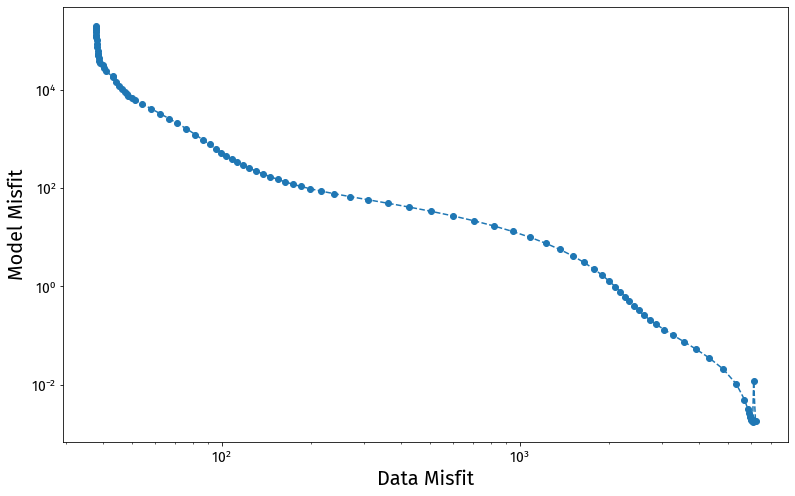

In [43]:
idx = 50
plt.figure(figsize=[13,8])
plt.loglog(*fsvals.T, 'o--',)
# plt.loglog(*fsvals[idx], 'ro')
# plt.title('L Curve of Fit by Tuning Parameter')
plt.xlabel('Data Misfit', font_properties=label_font)
plt.ylabel('Model Misfit', font_properties=label_font)
plt.xticks(font_properties=tick_font)
plt.yticks(font_properties=tick_font)


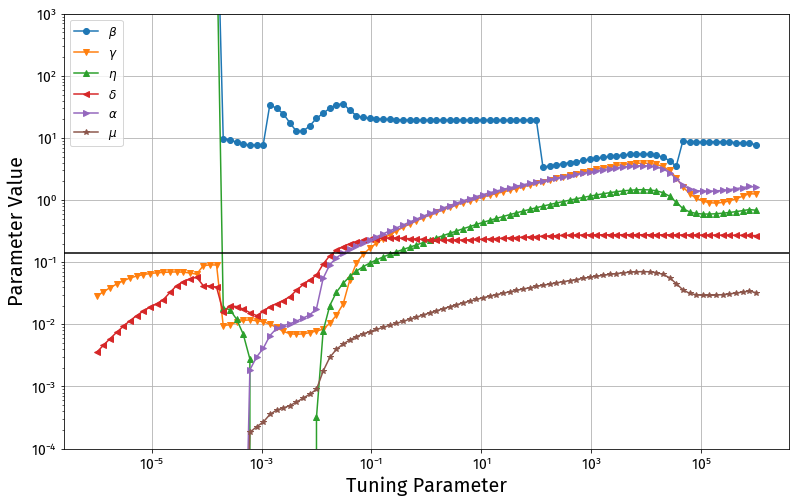

In [45]:
plt.figure(figsize=[13,8])
plt.plot(prange, [float(s['x'][-6]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-5]) for s in sols], 'v-', label=r'$\gamma$')
plt.plot(prange, [float(s['x'][-4]) for s in sols], '^-', label=r'$\eta$')
plt.plot(prange, [float(s['x'][-3]) for s in sols], '<-', label=r'$\delta$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], '>-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], '*-', label=r'$\mu$')
plt.axhline(1/7, color='k', alpha=1)
plt.xscale('log')
plt.yscale('log')
# plt.title('Regulariastion Paths of Parameter Estimates by Tuning Parameter')
plt.xlabel('Tuning Parameter', font_properties=label_font)
plt.ylabel('Parameter Value', font_properties=label_font)
plt.xticks(font_properties=tick_font)
plt.yticks(font_properties=tick_font)
plt.legend(fontsize='large')
plt.ylim([1e-4, 1e3])
plt.grid(True)


22.692


(0, 50)

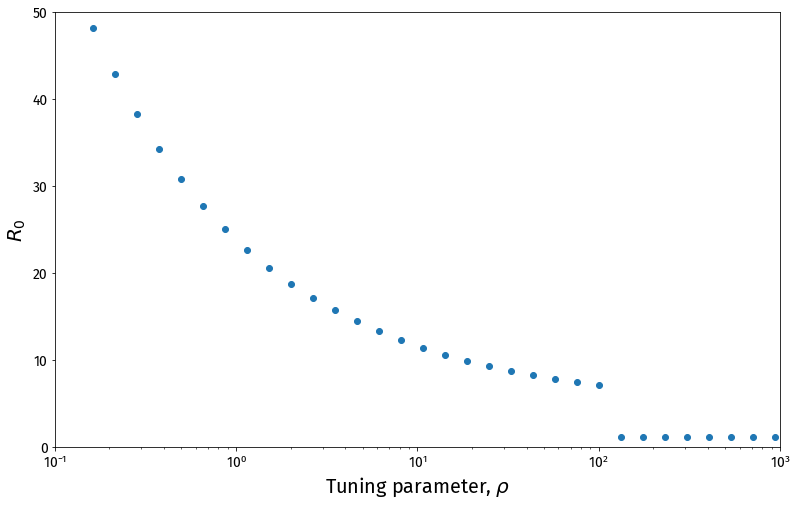

In [27]:
def r0(sol):
    b, g, e, d, a, m = getp(sol['x'])
    return (b)/(e+a+m)
plt.figure(figsize=[13,8], )
plt.plot(prange, [r0(sol) for sol in sols], 'o')
print(r0(sols[idx]))
plt.xscale('log')
plt.xlabel(r"Tuning parameter, $\rho$", font_properties=label_font)
plt.ylabel("$R_0$", font_properties=label_font)
plt.xticks(font_properties=tick_font)
plt.yticks(font_properties=tick_font)
plt.xlim([1e-1, 1e3])
plt.ylim([0,50])

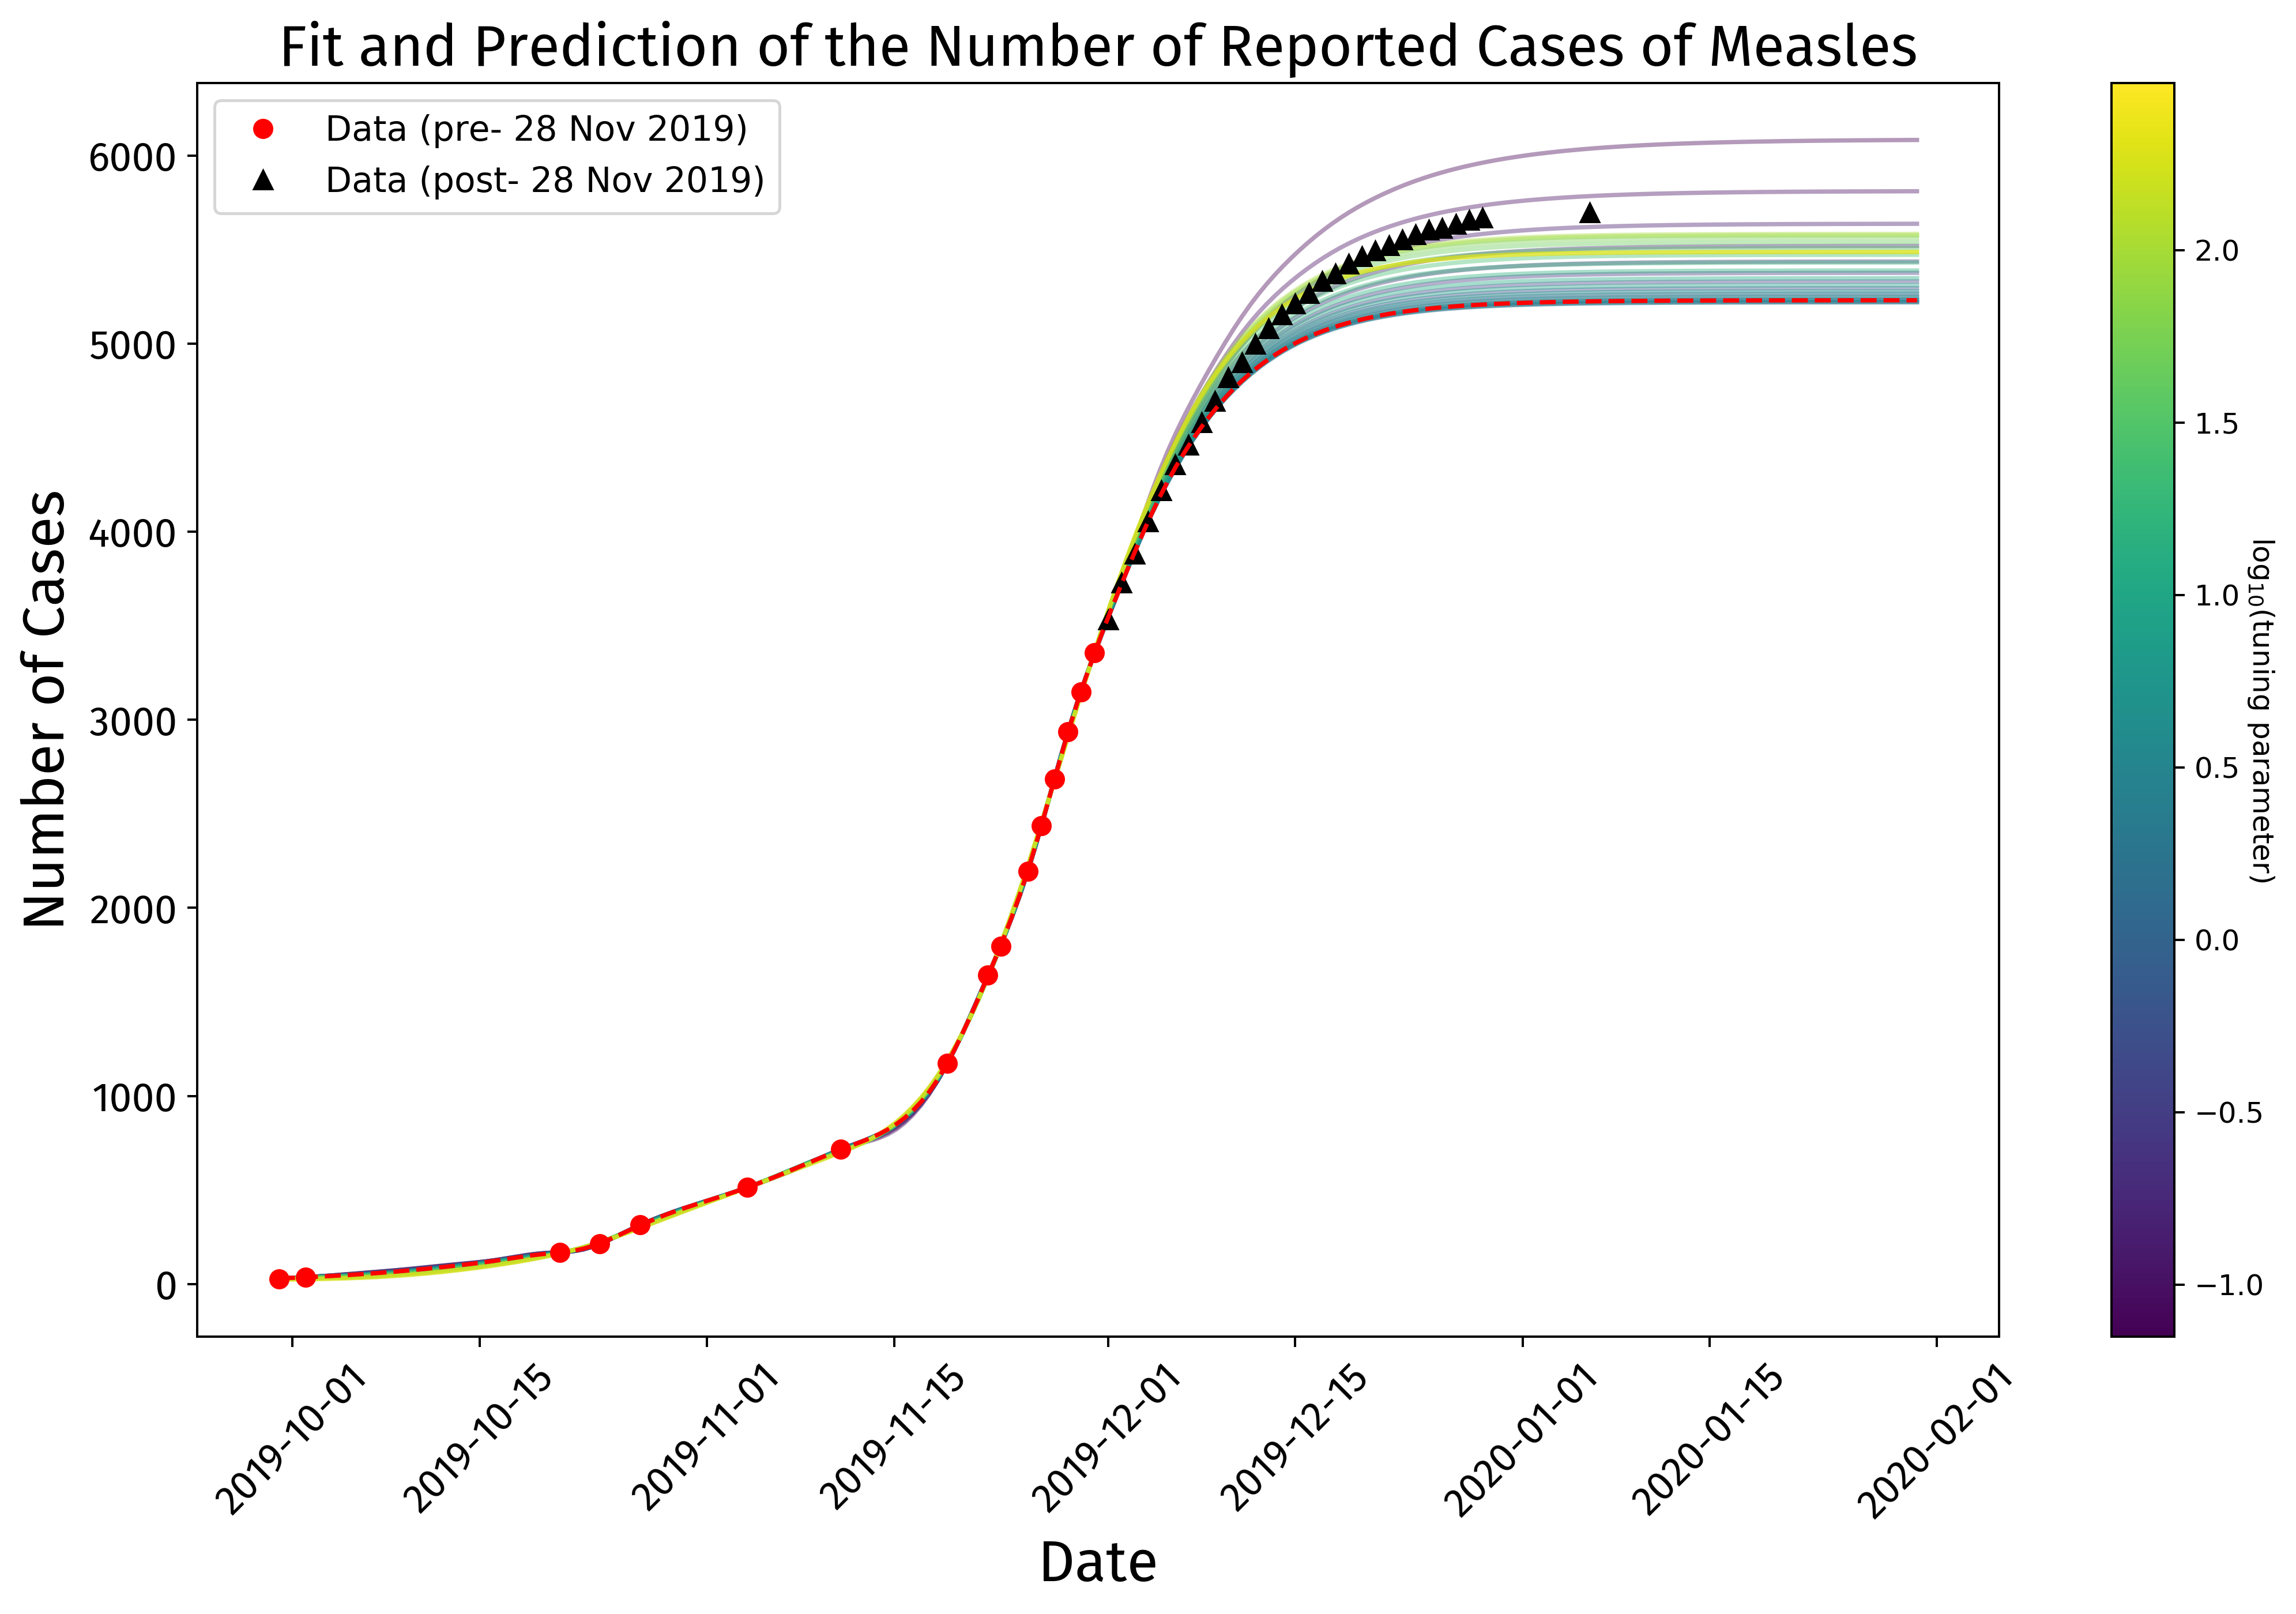

In [30]:
plt.figure(figsize=[14,8], dpi=360)

i0, i1 = (40, -30)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i,p in enumerate(prange[i0:i1:]):
    plt.plot(list(map(time_conv, model.observation_times)), getx(sols[i+i0]['x'])[-2], 
             color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(the_dates[start:clip], cE[start:clip], 'ro', label='Data (pre- 28 Nov 2019)')
plt.plot(the_dates[clip:], cE[clip:], 'k^', label='Data (post- 28 Nov 2019)')
plt.title("Fit and Prediction of the Number of Reported Cases of Measles", 
          font_properties=label_font)
plt.xlabel("Date", font_properties=label_font)
plt.ylabel("Number of Cases", font_properties=label_font)
plt.xticks(rotation=45, font_properties=tick_font)
plt.yticks(font_properties=tick_font)
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend(fontsize='large')
# plt.ylim([0,10000])

plt.plot(list(map(time_conv, model.observation_times)), getx(sols[idx]['x'])[-2], '--', color='r')

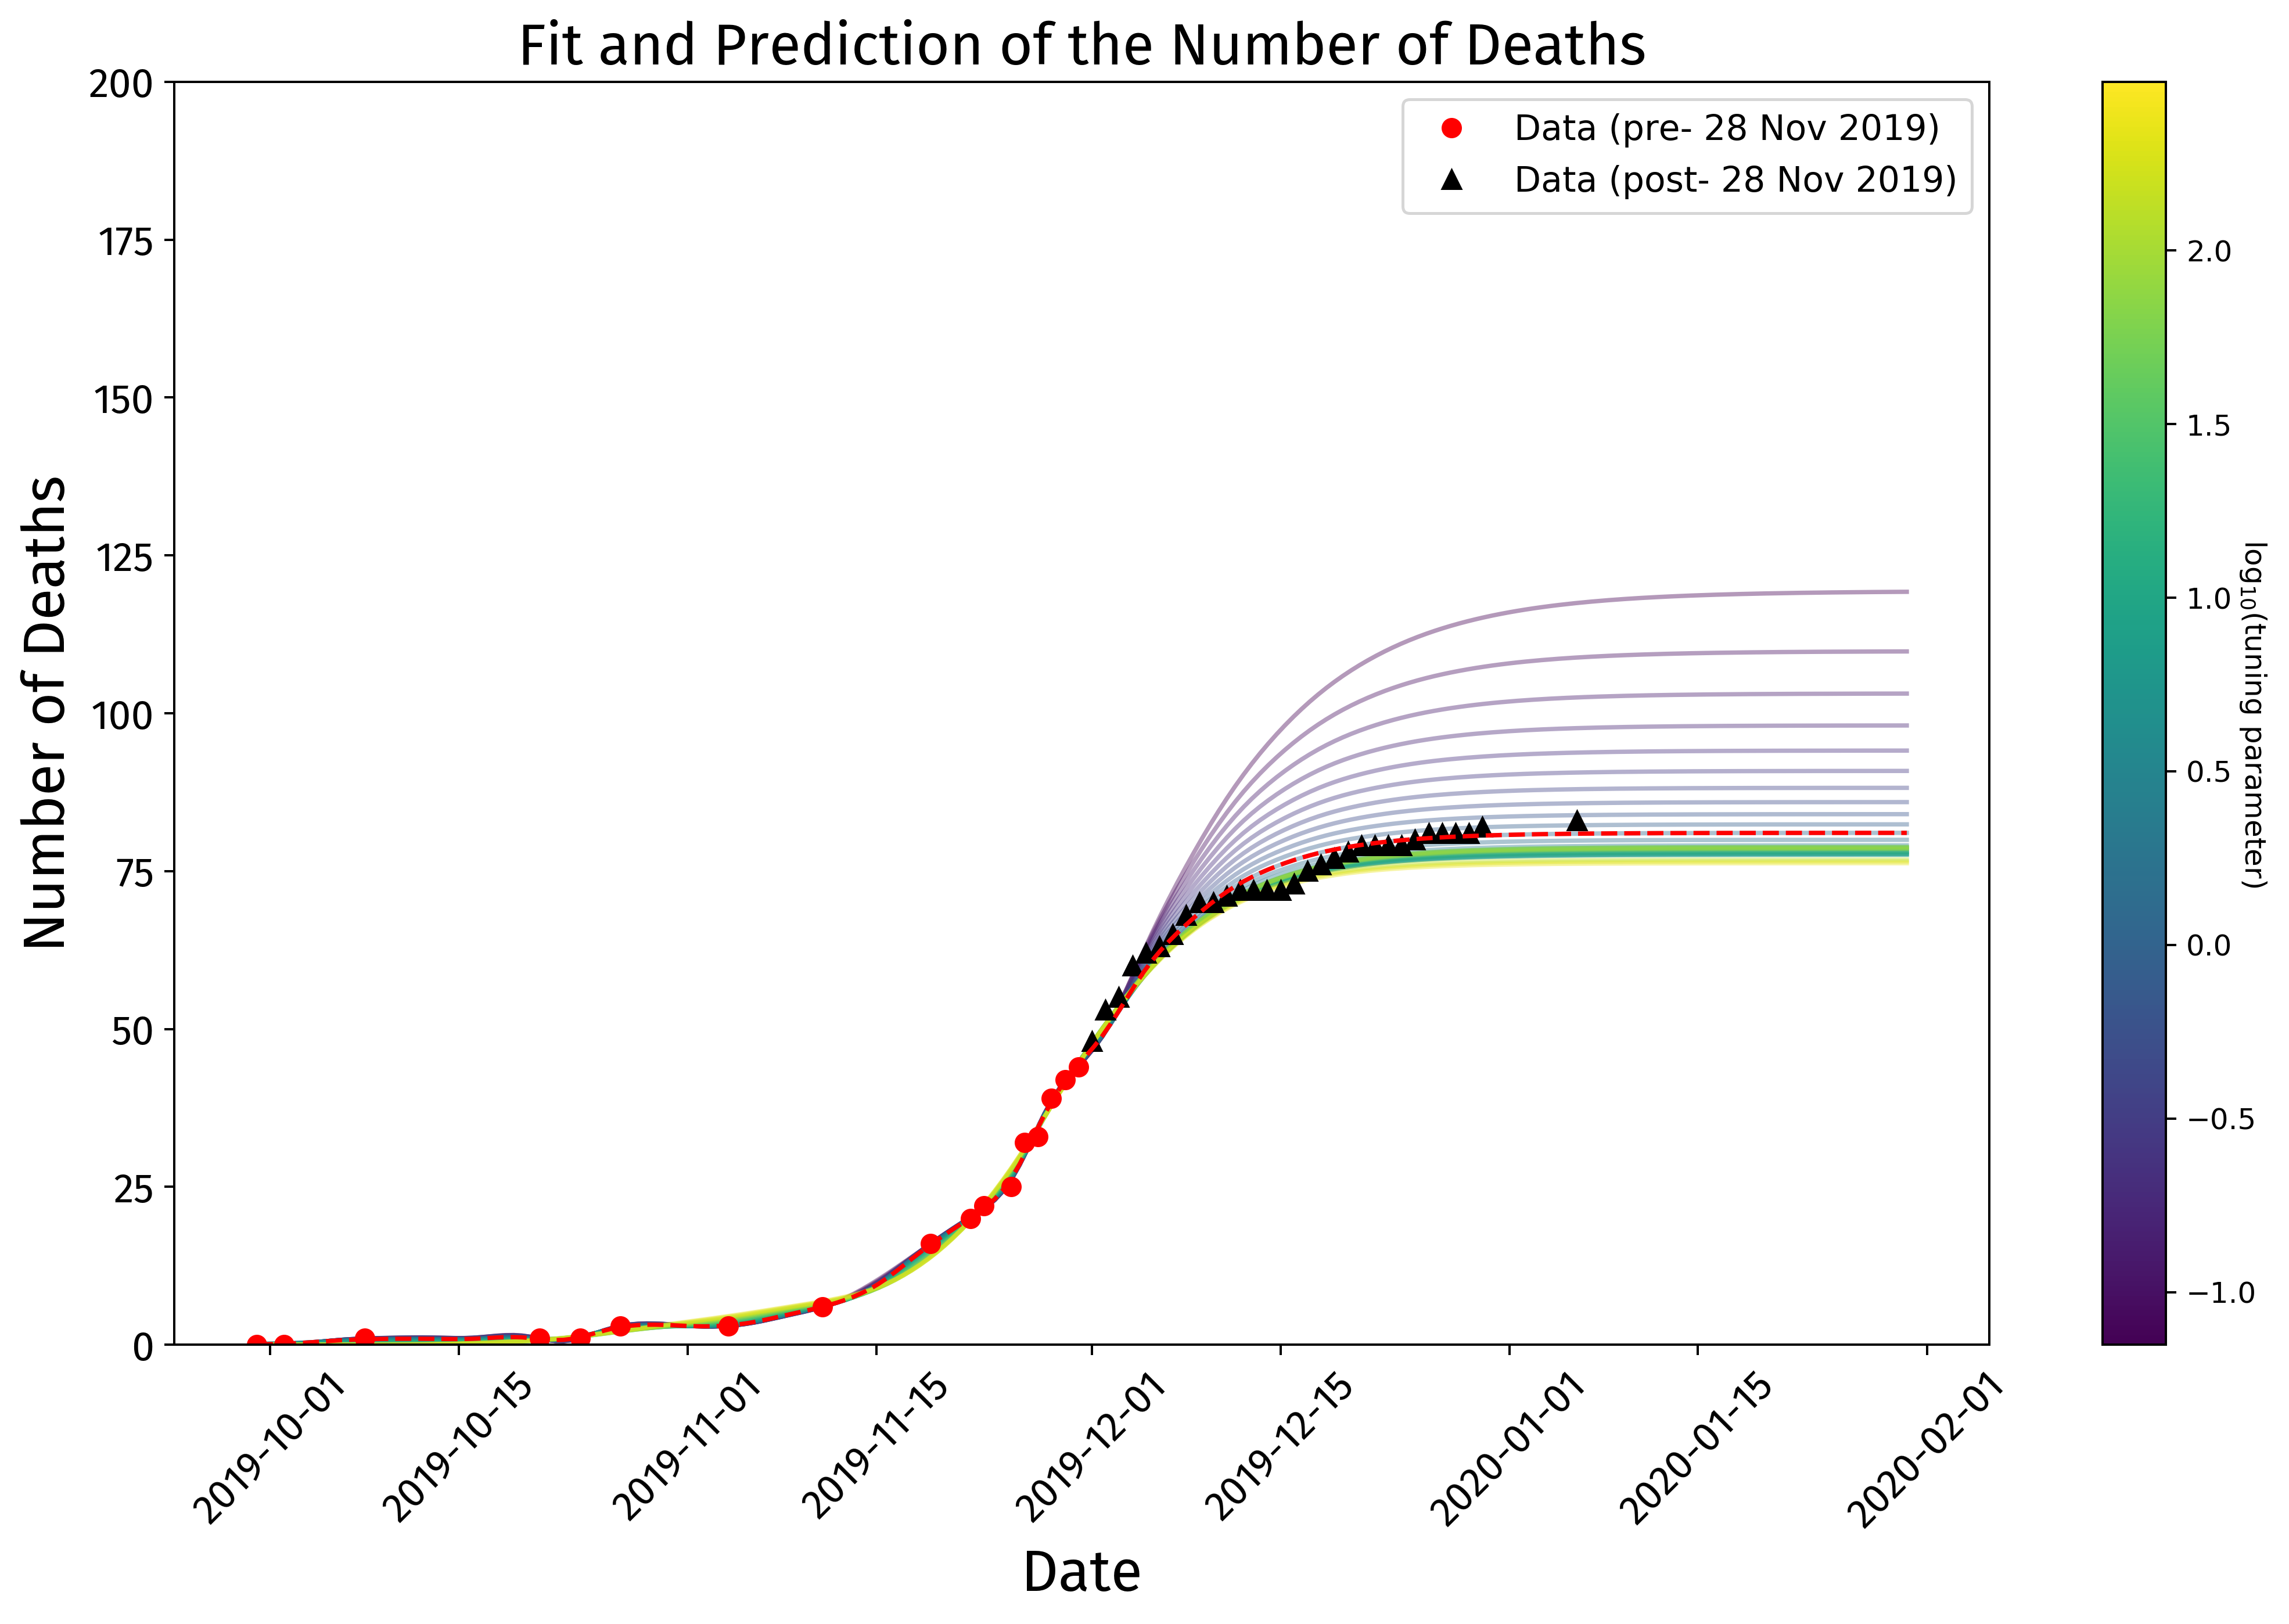

In [31]:
plt.figure(figsize=[14,8], dpi=360)

i0, i1 = (40, -30)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


for i,p in enumerate(prange[i0:i1:]):
    plt.plot(list(map(time_conv, model.observation_times)), getx(sols[i+i0]['x'])[6], 
             color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(the_dates[start:clip], D[start:clip], 'ro', label='Data (pre- 28 Nov 2019)')
plt.plot(the_dates[clip:], D[clip:], 'k^', label='Data (post- 28 Nov 2019)')
plt.title("Fit and Prediction of the Number of Deaths", font_properties=label_font)
plt.xlabel("Date", font_properties=label_font)
plt.ylabel("Number of Deaths", font_properties=label_font)
plt.xticks(rotation=45, font_properties=tick_font)
plt.yticks(font_properties=tick_font)
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend(fontsize='large')
plt.ylim([0, 200])

plt.plot(list(map(time_conv, model.observation_times)), getx(sols[idx]['x'])[6], '--', color='r')

Text(1e-05, 8545.5, 'True Final Size')

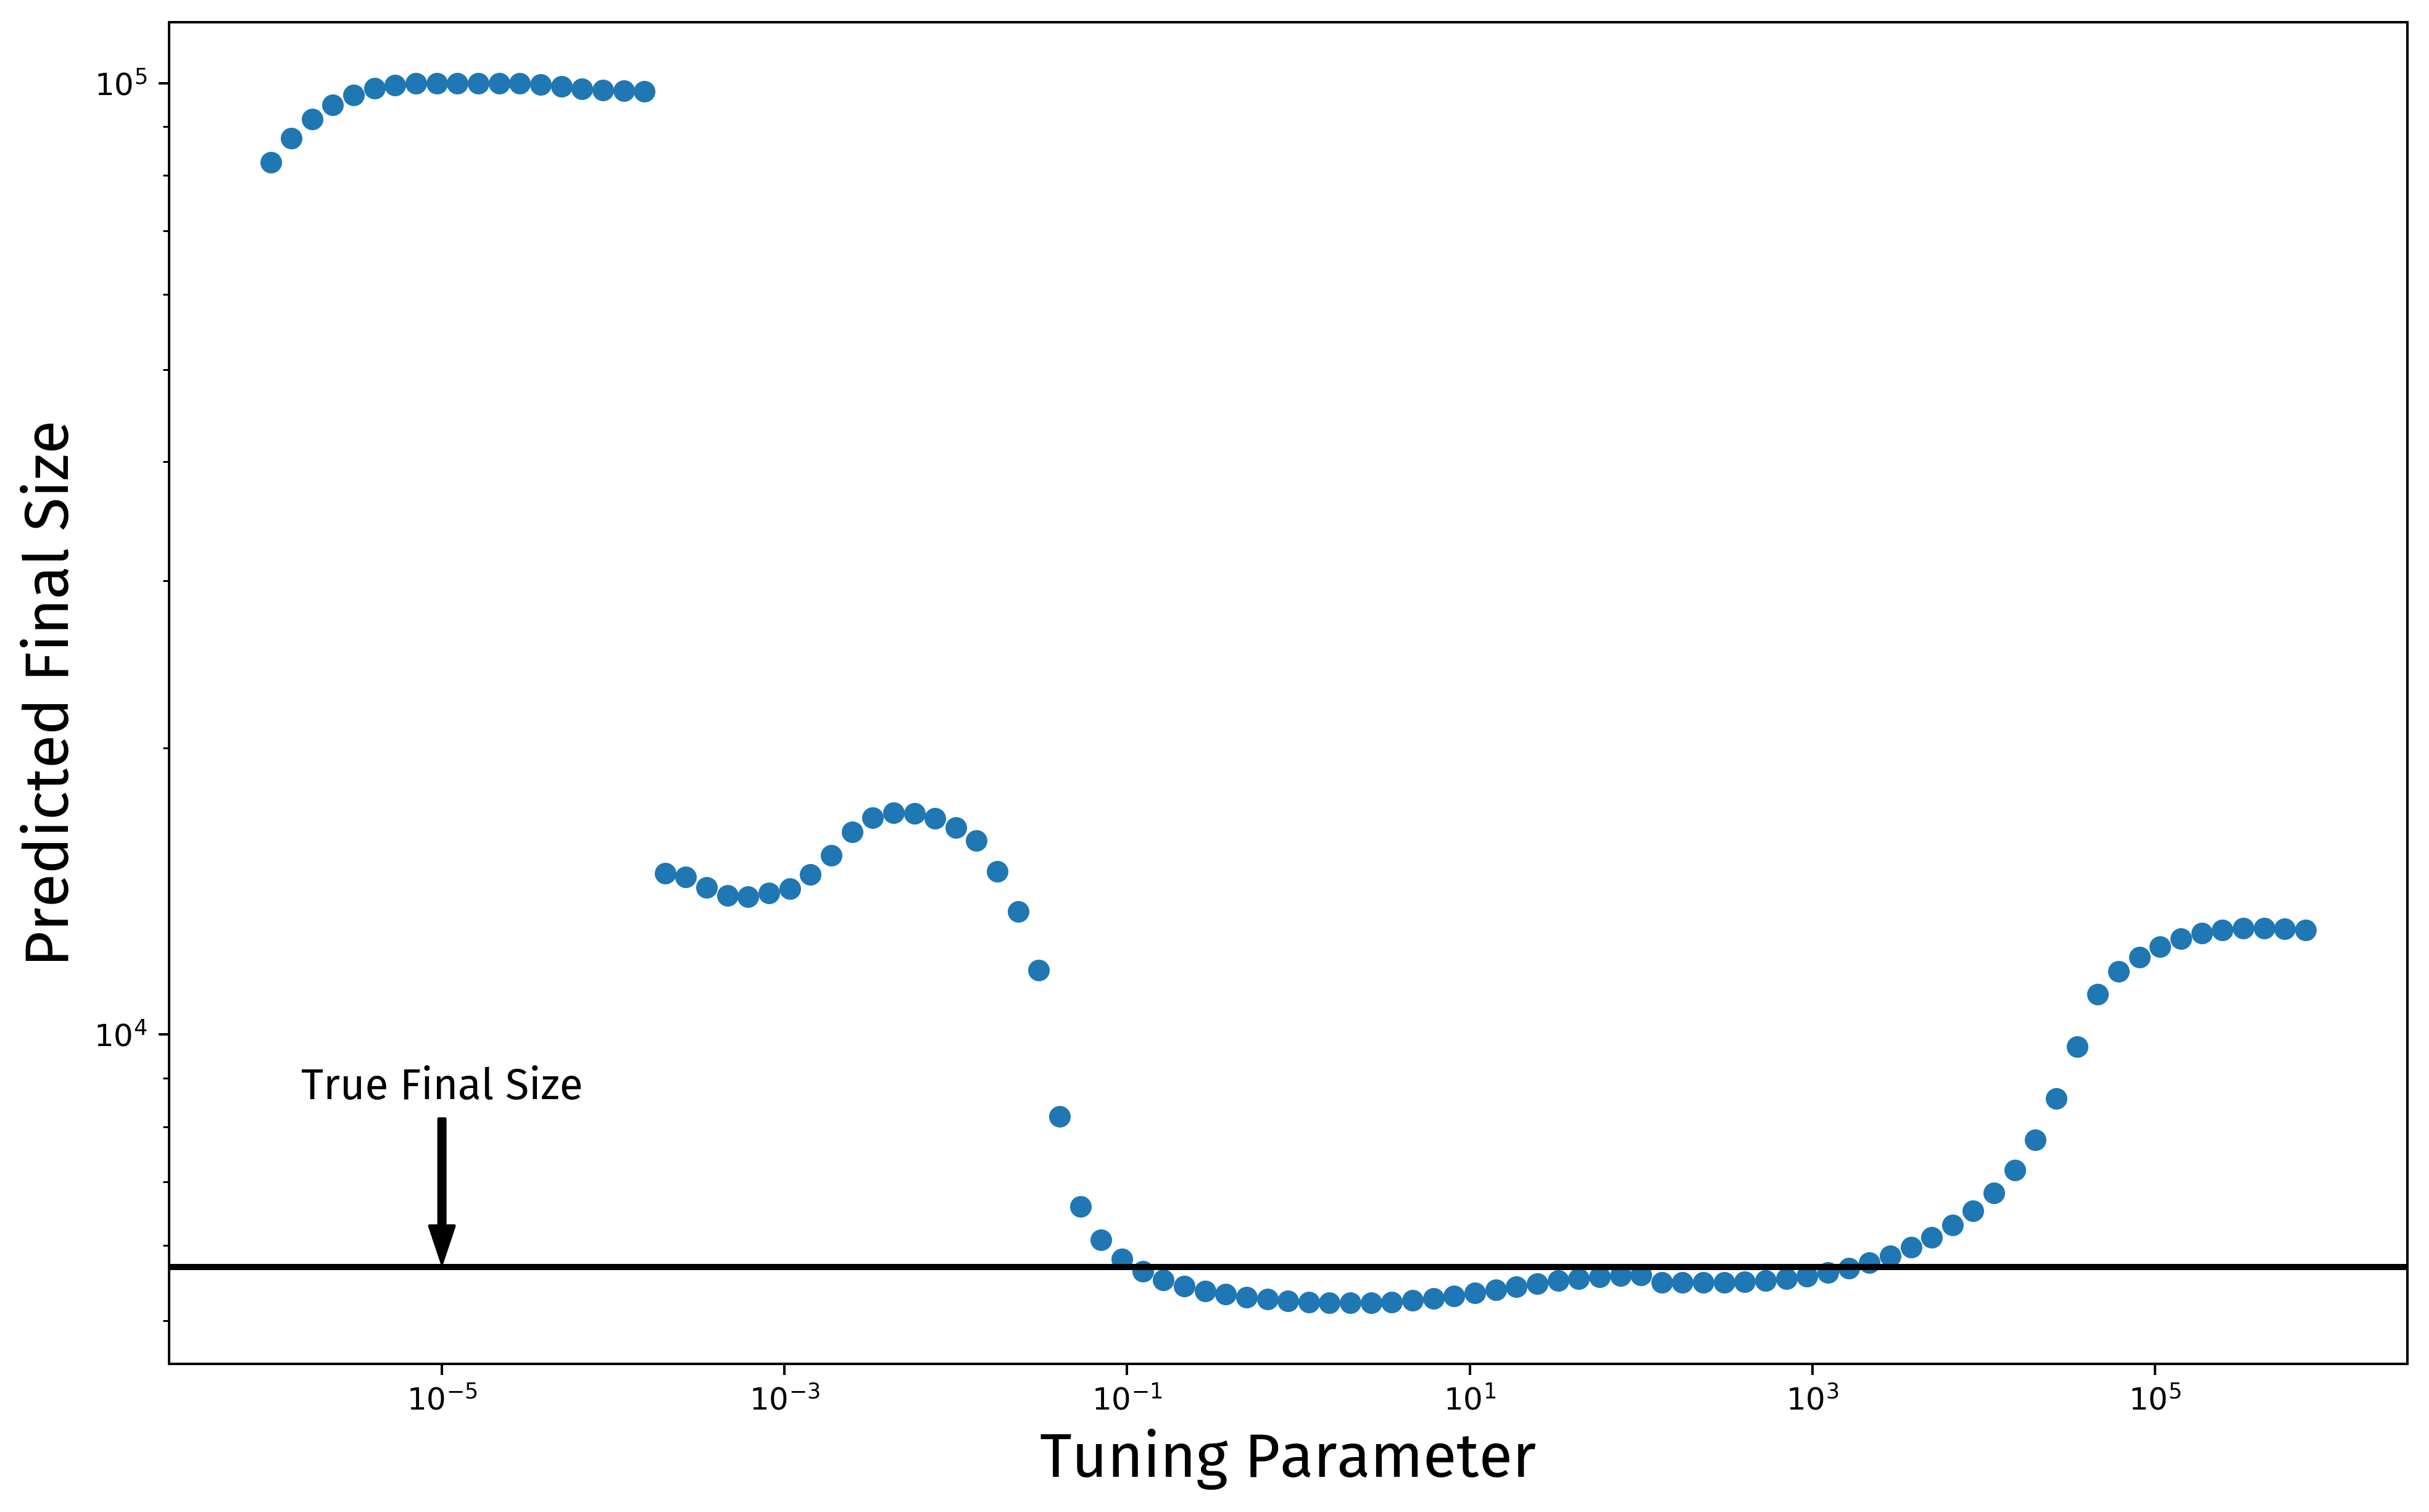

In [36]:
plt.figure(figsize=[13,8], dpi=360)
i0,i1 = (0, -1)
plt.plot(prange[i0:i1], [getx(sol['x'])[-2][-1] for sol in sols[i0:i1]],'o')
plt.xscale('log')

plt.axhline(cE[-1], color='k', linewidth=2)
plt.yscale('log')

# plt.title("Regularisation Path of Predicted Final Size by Tuning Parameter", font_properties=label_font)
plt.xlabel("Tuning Parameter", font_properties=label_font)
plt.ylabel("Predicted Final Size", font_properties=label_font)
plt.annotate('True Final Size', xy=(1e-5, cE[-1]), xytext=(1e-5, cE[-1]*1.5),
             arrowprops=dict(facecolor='black', shrink=0.025, width=2, headwidth=8),
             horizontalalignment="center", font_properties=tick_font
            )

Text(1e-05, 124.5, 'True Total Deaths')

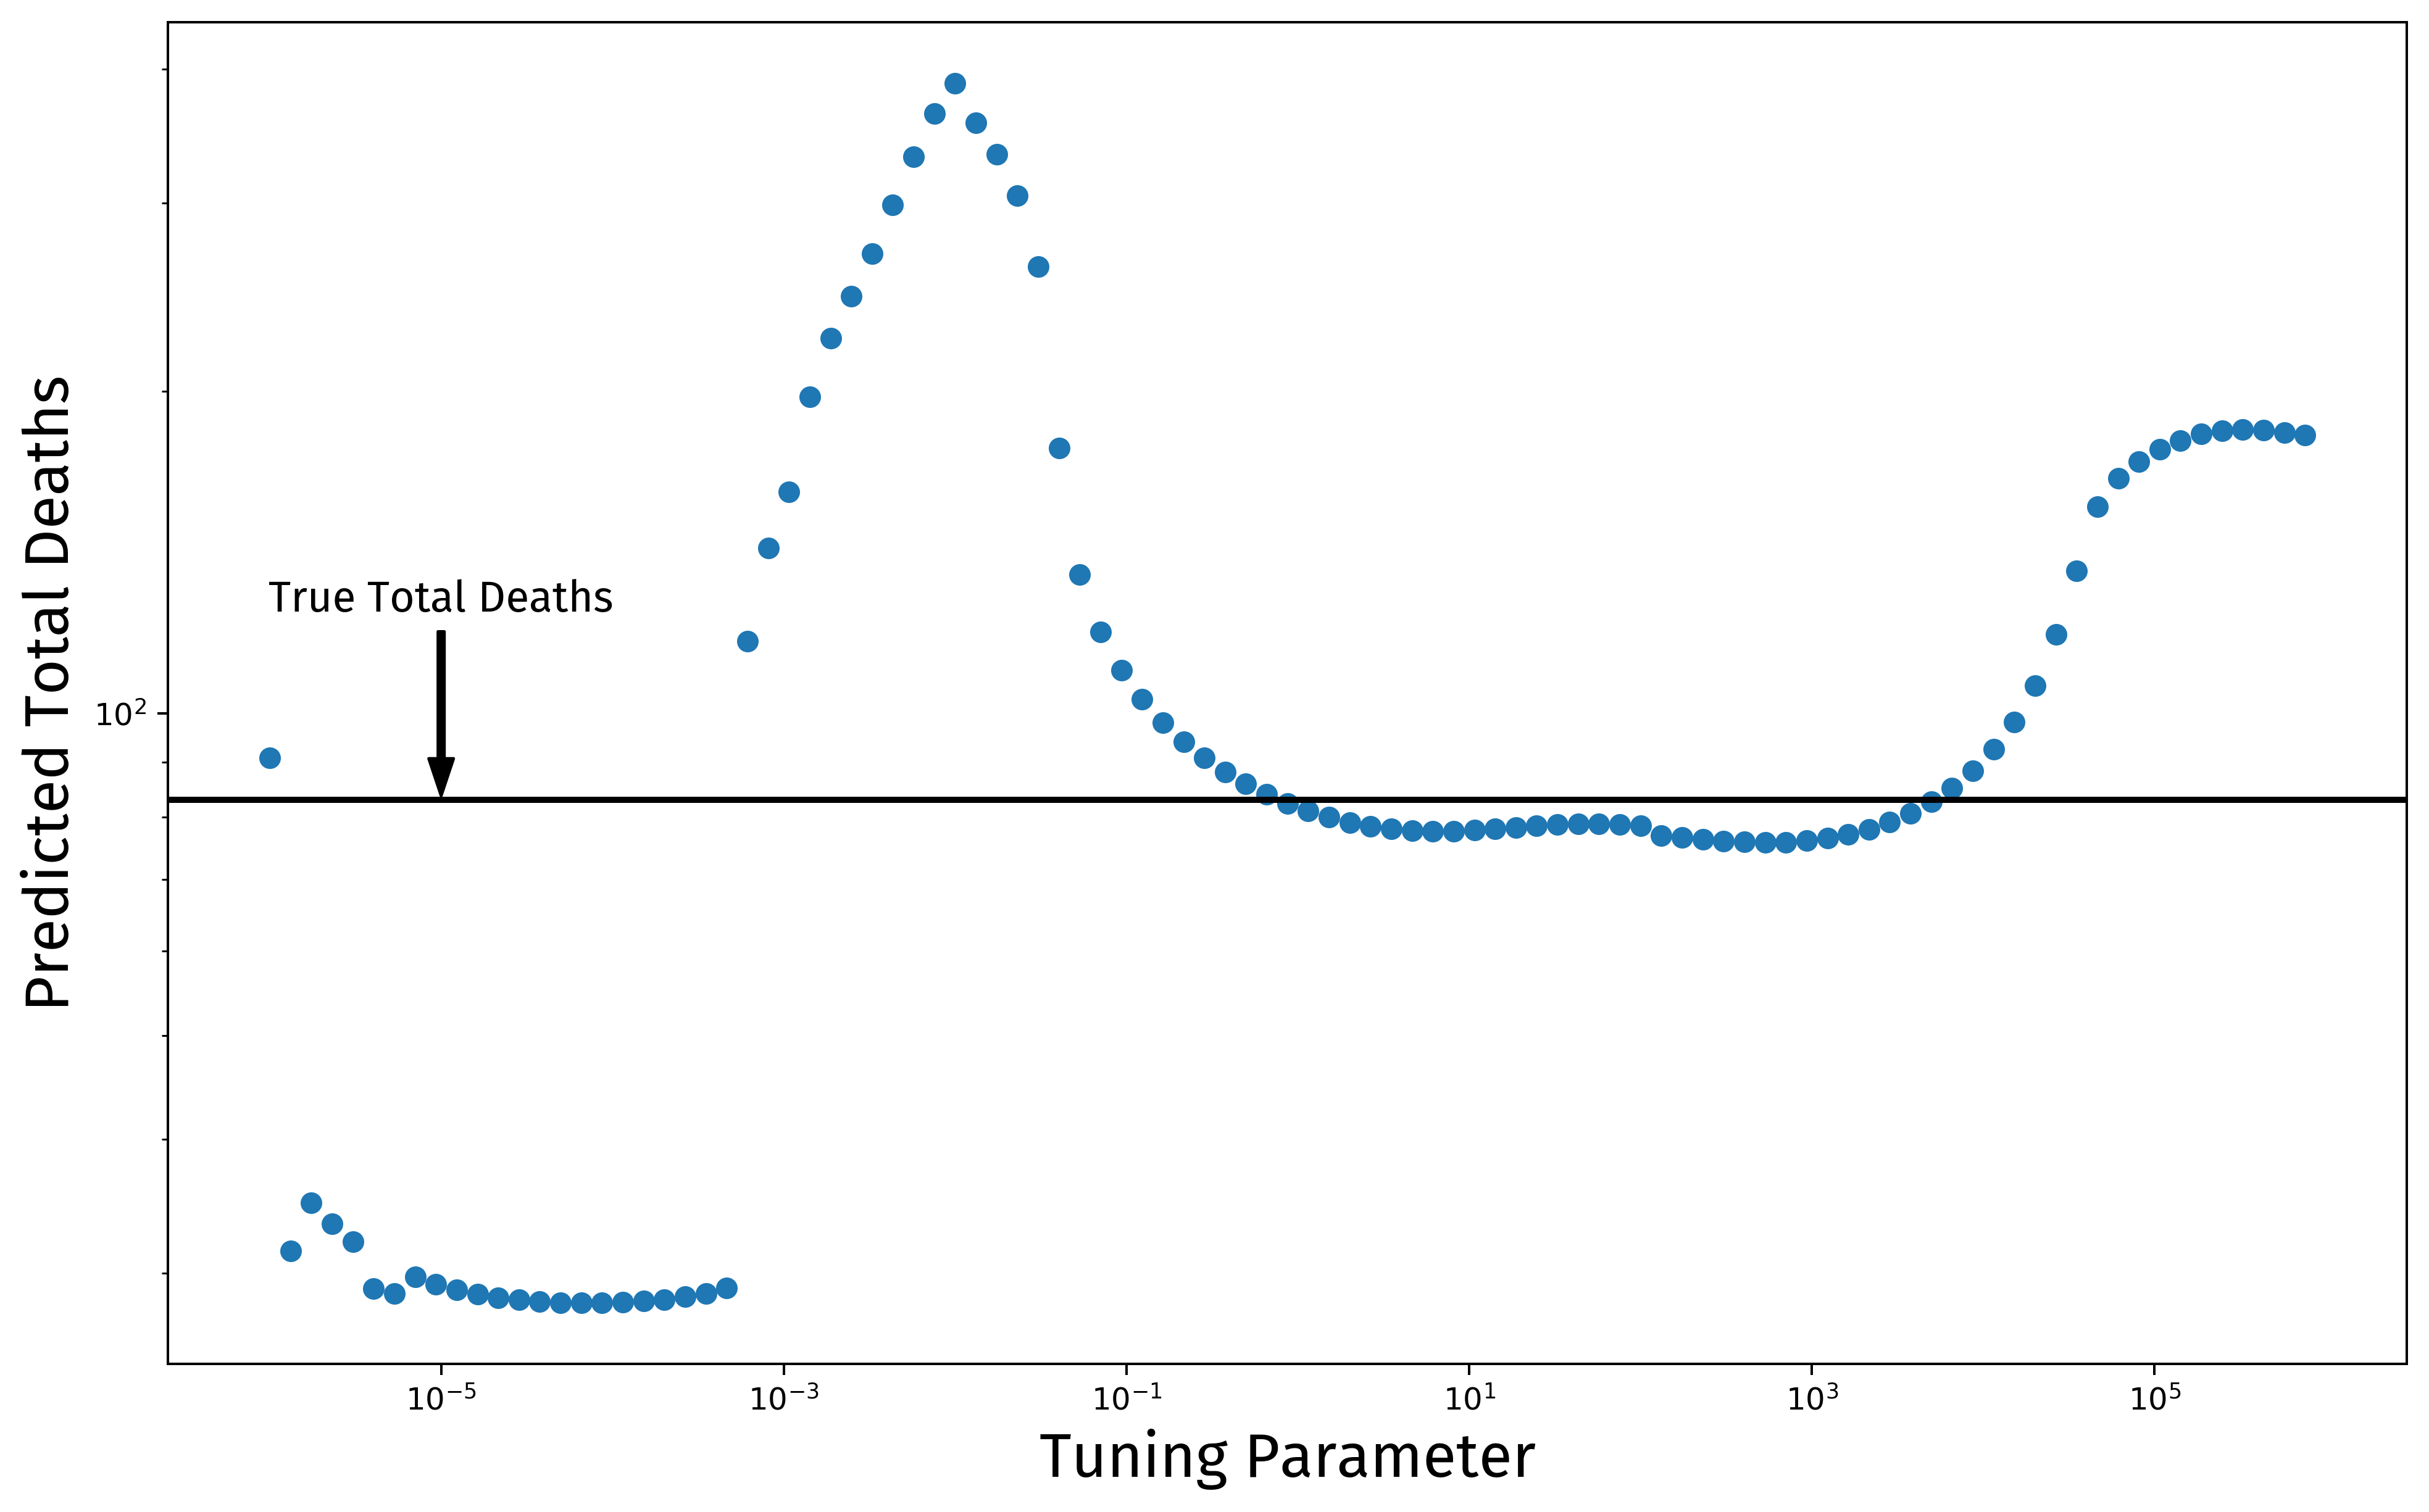

In [47]:
plt.figure(figsize=[13,8], dpi=360)
i0,i1 = (0, -1)
plt.plot( prange[i0:i1],[getx(sol['x'])[6][-1] for sol in sols[i0:i1]],'o')
# plt.xscale('log')

plt.axhline(D[-1], color='k', linewidth=2)
plt.xscale('log')
plt.yscale('log')

# plt.title("Predicted Total Deaths by Tuning Parameter", font_properties=label_font)
plt.xlabel("Tuning Parameter", font_properties=label_font)
plt.ylabel("Predicted Total Deaths", font_properties=label_font)
plt.annotate('True Total Deaths', xy=(1e-5, D[-1]), xytext=(1e-5, D[-1]*1.5),
             arrowprops=dict(facecolor='black', shrink=0.025, width=2, headwidth=8),
             horizontalalignment="center", font_properties=tick_font
            )